In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML
from trend_following import (jupyter_interactive_mode, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             sharpe_ratio, create_trend_strategy, get_close_prices)

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [3]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

File data found...reading ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data


In [4]:
def calculate_ts_momentum(df, close_px_col, lookback_period, period_name, returns_type='arithmetic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_log_returns'].rolling(window=lookback_period).sum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_pct_returns'].rolling(window=lookback_period).sum()
    
    return df

## THIS IS NON-COMPOUNDED RETURNS
def calculate_cumulative_returns(df, close_px_col, returns_type='logarithmic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_log_cum_returns'] = df[f'{close_px_col}_log_returns'].cumsum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_pct_cum_returns'] = df[f'{close_px_col}_pct_returns'].cumsum()
    
    return df

In [5]:
def get_long_and_short_term_momentum(df, close_px_col, returns_type, weekend_trading=False):
    
    if weekend_trading:
        trading_lookback_periods = [10, 21, 63, 126, 252]
    else:
        trading_lookback_periods = [10, 30, 90, 180, 365]
        
    lookback_period_names = ['10_day', '1_month', '3_month', '6_month', '12_month']
    
    c = 0
    for lookback in trading_lookback_periods:
        df = calculate_ts_momentum(df, close_px_col, lookback_period=lookback, period_name=lookback_period_names[c], returns_type=returns_type)
        c+=1
    
    return df

In [6]:
def generate_momentum_signal(df, ticker, momentum_type, threshold):#, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    df[f'{ticker}_{momentum_type}_signal'] = np.where(df[f'{ticker}_{momentum_type}'] > threshold, 1,
                                             np.where(df[f'{ticker}_{momentum_type}'] < -threshold, -1, np.nan))
    df[f'{ticker}_{momentum_type}_signal'] = df[f'{ticker}_{momentum_type}_signal'].shift(1)
    
    df[f'{ticker}_daily_returns'] = df[f'{ticker}'].pct_change()
    
#     if include_transaction_costs_and_fees:
#         average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
#         df[f'{ticker}_{momentum_type}_strategy_returns'] = (df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns'] -
#                                                             (transaction_cost_est + average_fee_per_trade))
#     else:
    df[f'{ticker}_{momentum_type}_strategy_returns'] = df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns']
    df[f'{ticker}_{momentum_type}_strategy_trades'] = df[f'{ticker}_{momentum_type}_signal'].diff()
    
    # Calculate cumulative returns
    df[f'{ticker}_{momentum_type}_cum_strategy_returns'] = (1 + df[f'{ticker}_{momentum_type}_strategy_returns']).cumprod() - 1
    df[f'{ticker}_{momentum_type}_cum_buy_and_hold_returns'] = (1 + df[f'{ticker}_daily_returns']).cumprod() - 1
    
    return df

In [7]:
def estimate_fee_per_trade(passive_trade_rate=0.5):
    ## Maker/Taker Fee based on lowest tier at Coinbase
    maker_fee = 0.006  # 0.6%
    taker_fee = 0.012  # 1.20%
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)

    average_fee_per_trade = (maker_fee * proportion_maker) + (taker_fee * proportion_taker)
    
    return average_fee_per_trade

In [8]:
def calculate_drawdown(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        adjusted_daily_returns = df[strategy_daily_return_col] - (np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade))
        df['strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1
    else:
        df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1
    df[f'strategy_cumulative_return_cum_max'] = df['strategy_cumulative_return'].cummax()
    df[f'strategy_cumulative_return_drawdown'] = df['strategy_cumulative_return'] - df[f'strategy_cumulative_return_cum_max']
    df[f'strategy_cumulative_return_drawdown_pct'] = df[f'strategy_cumulative_return_drawdown'] / df[f'strategy_cumulative_return_cum_max']
    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    
    # Calculate maximum drawdown
    max_drawdown = df[f'strategy_cumulative_return_drawdown_pct'].min()
    
    # Calculate maximum drawdown duration
    df['End'] = df.index
    df['Start'] = df[f'strategy_cumulative_return_cum_max'].ne(df[f'strategy_cumulative_return_cum_max'].shift(1)).cumsum()
    df[f'strategy_cumulative_return_DDDuration'] = df.groupby('Start')['End'].transform(lambda x: x.max() - x.min())
    max_drawdown_duration = df[f'strategy_cumulative_return_DDDuration'].max()

    # Drop NaN values for better display
#     df = df.dropna(inplace=True)
    return df, max_drawdown, max_drawdown_duration

In [9]:
def calculate_compounded_cumulative_returns(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                                            transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1

    # Calculate the total cumulative return at the end of the period
    total_cumulative_return = df['strategy_cumulative_return'].iloc[-1]

    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        num_trades = np.abs(df[strategy_trade_count_col]).sum()
        total_transaction_cost = num_trades * transaction_cost_est
        total_fee_cost = num_trades * average_fee_per_trade
        total_cumulative_return = total_cumulative_return - (total_transaction_cost + total_fee_cost)
    
    return total_cumulative_return

In [10]:
def calculate_CAGR(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                   transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    total_cumulative_return = calculate_compounded_cumulative_returns(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col,
                                                                     annual_trading_days=annual_trading_days, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                     transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate CAGR
    # Calculate the number of periods (days)
    num_periods = len(df)

    # Convert the number of periods to years (assuming daily data, 252 trading days per year)
    trading_days_per_year = annual_trading_days
    num_years = num_periods / trading_days_per_year
    annualized_return = (1 + total_cumulative_return) ** (1 / num_years) - 1
    
    return annualized_return

In [307]:
def calculate_calmar_ratio(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                           transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate CAGR
    cagr = calculate_CAGR(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=annual_trading_days, 
                          include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                          transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Max Drawdown
    _, max_drawdown, _ = calculate_drawdown(df, strategy_daily_return_col, strategy_trade_count_col,
                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees, 
                                            transaction_cost_est=transaction_cost_est, 
                                            passive_trade_rate=passive_trade_rate)
    
    # Calculate Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown)
    
    return calmar_ratio

In [11]:
def calculate_hit_rate(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Identify profitable trades (daily returns > 0)
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        df['profitable_trade'] = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)) > 0
    else:
        df['profitable_trade'] = df[strategy_daily_return_col] > 0

    # Calculate hit rate
    total_trades = df['profitable_trade'].count()
    profitable_trades = df['profitable_trade'].sum()
    hit_rate = profitable_trades / total_trades
    
    return hit_rate

In [12]:
from scipy import stats
def calculate_t_stat(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                    passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        mean_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).mean()
        std_dev_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).std()
    else:
        mean_return = df[strategy_daily_return_col].mean()
        std_dev_return = df[strategy_daily_return_col].std()
        
    num_days = len(df[strategy_daily_return_col])
    t_stat = mean_return/(std_dev_return/np.sqrt(num_days))
    p_value = stats.t.sf(np.abs(t_stat), df=num_days-1) * 2
    
    return t_stat, p_value

In [17]:
def calculate_annualized_std_dev(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                 passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        annualized_std_dev = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) *
                              (transaction_cost_est + average_fee_per_trade)).std() * np.sqrt(annual_trading_days)
    else:
        annualized_std_dev = df[strategy_daily_return_col].std() * np.sqrt(annual_trading_days)
    
    return annualized_std_dev

In [311]:
def calculate_risk_and_performance_metrics(df, strategy_daily_return_col, strategy_trade_count_col, annual_rf=0.05, annual_trading_days=252, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                           passive_trade_rate=0.5):
    
    # Calculate CAGR
    annualized_return = calculate_CAGR(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                       include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Sharpe Ratio
    annualized_sharpe_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days, annual_rf=annual_rf,
                                           include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Calmar Ratio
    calmar_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days, 
                                include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Standard Deviation
    annualized_std_dev = calculate_annualized_std_dev(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                                      include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Max Drawdown
    df, max_drawdown, max_drawdown_duration = calculate_drawdown(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, 
                                                                 include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Hit Rate
    hit_rate = calculate_hit_rate(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                  transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate T-Stat and P-Value
    t_stat, p_value = calculate_t_stat(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                       transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Count of trades
    total_num_trades = np.abs(df[strategy_trade_count_col]).sum()
    
    performance_metrics = {'annualized_return': annualized_return,
                           'annualized_sharpe_ratio': annualized_sharpe_ratio,
                           'calmar_ratio': calmar_ratio,
                           'annualized_std_dev': annualized_std_dev,
                           'max_drawdown': max_drawdown,
                           'max_drawdown_duration': max_drawdown_duration,
                           'hit_rate': hit_rate,
                           't_statistic': t_stat,
                           'p_value': p_value,
                           'trade_count': total_num_trades}
    
    return performance_metrics

In [15]:
ticker = '^VIX'
data_VIX = get_close_prices(start_date, end_date, ticker)

File data found...reading ['^VIX'] data


In [ ]:
data_VIX.head()

In [315]:
ticker_list = ['ETH-USD','XRP-USD','SOL-USD','BCH-USD','BTC-USD',]
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns',
                                                         strategy_trade_count_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_trades', annual_trading_days=365,
                                                         include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

ETH-USD
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
XRP-USD
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
SOL-USD
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
BCH-USD
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...read

In [316]:
df_final

annualized_return  \
ETH-USD_10_day_momentum_strategy_returns                     0.877931   
ETH-USD_1_month_momentum_strategy_returns                    0.248406   
ETH-USD_3_month_momentum_strategy_returns                   -0.140725   
ETH-USD_6_month_momentum_strategy_returns                    0.838204   
ETH-USD_12_month_momentum_strategy_returns                   0.137973   
ETH-USD_12_month_minus_1_month_momentum_strateg...          -0.047961   
XRP-USD_10_day_momentum_strategy_returns                    -0.855810   
XRP-USD_1_month_momentum_strategy_returns                   -0.189686   
XRP-USD_3_month_momentum_strategy_returns                   -0.814846   
XRP-USD_6_month_momentum_strategy_returns                   -0.808679   
XRP-USD_12_month_momentum_strategy_returns                  -0.501017   
XRP-USD_12_month_minus_1_month_momentum_strateg...          -0.372334   
SOL-USD_10_day_momentum_strategy_returns                     6.234485   
SOL-USD_1_month_momentum_strategy_returns                    4.053466   
SOL-USD_3_month_momentum_strategy_returns                    3.660057   
SOL-USD_6_month_momentum_strategy_returns                    2.201330   
SOL-USD_12_month_momentum_strategy_returns                   3.074999   
SOL-USD_12_month_minus_1_month_momentum_strateg...           1.949836   
BCH-USD_10_day_momentum_strategy_returns                     1.269603   
BCH-USD_1_month_momentum_strategy_returns                   -0.435432   
BCH-USD_3_month_momentum_strategy_returns                   -0.354892   
BCH-USD_6_month_momentum_strategy_returns                   -0.151919   
BCH-USD_12_month_momentum_strategy_returns                  -0.103964   
BCH-USD_12_month_minus_1_month_momentum_strateg...          -0.302489   
BTC-USD_10_day_momentum_strategy_returns                    -0.216464   
BTC-USD_1_month_momentum_strategy_returns                    1.097953   
BTC-USD_3_month_momentum_strategy_returns                    0.680214   
BTC-USD_6_month_momentum_strategy_returns                    0.959812   
BTC-USD_12_month_momentum_strategy_returns                   0.773027   
BTC-USD_12_month_minus_1_month_momentum_strateg...           0.787149   

                                                    annualized_sharpe_ratio  \
ETH-USD_10_day_momentum_strategy_returns                           1.087068   
ETH-USD_1_month_momentum_strategy_returns                          0.690066   
ETH-USD_3_month_momentum_strategy_returns                          0.293225   
ETH-USD_6_month_momentum_strategy_returns                          1.076971   
ETH-USD_12_month_momentum_strategy_returns                         0.533969   
ETH-USD_12_month_minus_1_month_momentum_strateg...                 0.321786   
XRP-USD_10_day_momentum_strategy_returns                          -0.451493   
XRP-USD_1_month_momentum_strategy_returns                          0.527155   
XRP-USD_3_month_momentum_strategy_returns                         -0.867878   
XRP-USD_6_month_momentum_strategy_returns                         -0.579378   
XRP-USD_12_month_momentum_strategy_returns                        -0.071319   
XRP-USD_12_month_minus_1_month_momentum_strateg...                 0.114279   
SOL-USD_10_day_momentum_strategy_returns                           1.969223   
SOL-USD_1_month_momentum_strategy_returns                          1.782248   
SOL-USD_3_month_momentum_strategy_returns                          1.780061   
SOL-USD_6_month_momentum_strategy_returns                          1.511666   
SOL-USD_12_month_momentum_strategy_returns                         1.699622   
SOL-USD_12_month_minus_1_month_momentum_strateg...                 1.447540   
BCH-USD_10_day_momentum_strategy_returns                           1.239503   
BCH-USD_1_month_momentum_strategy_returns                          0.304125   
BCH-USD_3_month_momentum_strategy_returns                          0.168759   
BCH-USD_6_month_momentum_strategy_returns         

In [ ]:
data.head()

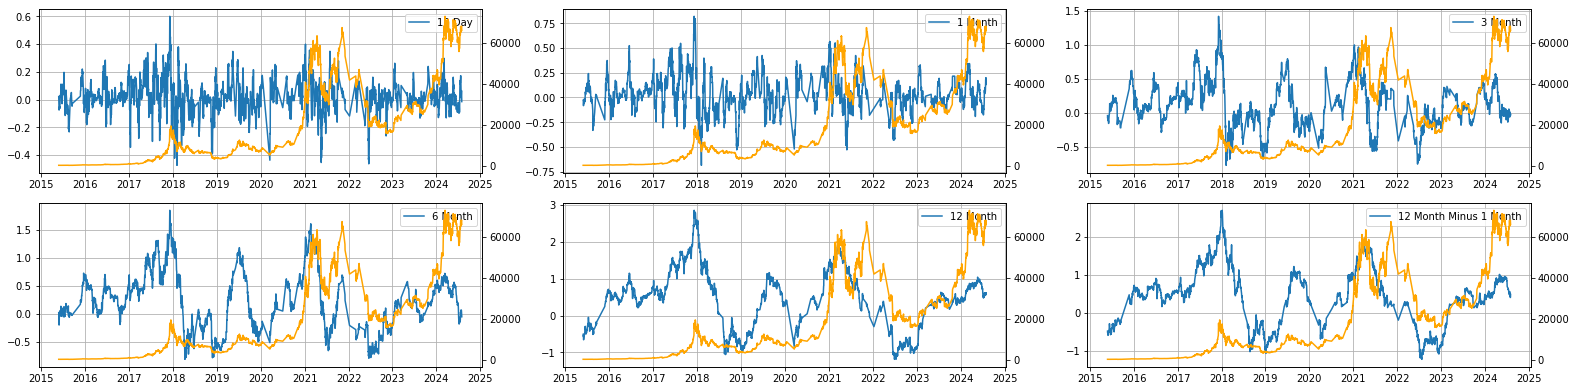

In [317]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_1 = momentum_ax_1.twinx()
_ = momentum_ax_1.plot(data.index, data[f'{ticker}_10_day_momentum'], label='10 Day')
_ = momentum_twin_ax_1.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_2 = momentum_ax_2.twinx()
_ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
_ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_3 = momentum_ax_3.twinx()
_ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
_ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = momentum_ax_1.grid()
_ = momentum_ax_1.legend()
_ = momentum_ax_2.grid()
_ = momentum_ax_2.legend()
_ = momentum_ax_3.grid()
_ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()

plt.tight_layout()

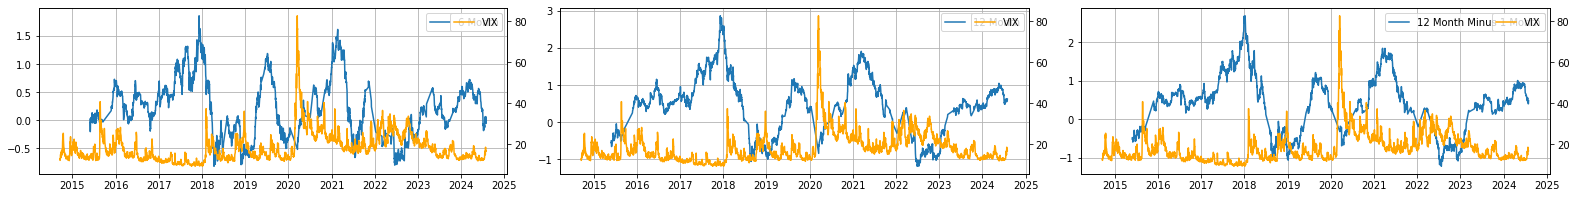

In [318]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
# momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
# momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

# _ = momentum_ax_1.grid()
# _ = momentum_ax_1.legend()
# _ = momentum_ax_2.grid()
# _ = momentum_ax_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_twin_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_twin_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()
_ = momentum_twin_ax_6.legend()

plt.tight_layout()

In [319]:
data['BTC-USD'].corr(data_VIX['^VIX'])

0.0738994249792974

In [ ]:
def generate_trend_signal(df, mavg_slope_col_list, ticker='BTC-USD'):
    
    def slope_signal(row):
        if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
            return 'downtrend'
        elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
            return 'uptrend'
        
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)

    return df

In [ ]:
for end in np.linspace(200, 600, 3):
    print(end)

In [ ]:
for end in np.arange(200, 1000, 50):
    for start in np.arange(10, end, 10):
        for stepsizes in np.arange(1,10,1):
            print(start, end, end/start*stepsizes)

In [198]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BTC-USD']#,'ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

File data found...reading ['BTC-USD'] data


In [199]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
ticker = 'BTC-USD'
data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

In [200]:
mavg_start = 30
mavg_end = 300
mavg_stepsize = 2
ticker = 'BTC-USD'
data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

## Correlation of Signals

In [419]:
# short_mavg_window = [10,20,10,20,30,30,40,50,100,90]
# long_mavg_window = [100,200,100,200,300,300,400,500,1000,900]
short_mavg_window = [10, 50, 100, 200]
long_mavg_window = [50, 100, 200, 500]
mavg_stepsize_list = [2,4]

In [420]:
print(len(short_mavg_window))
print(len(long_mavg_window))
print(len(mavg_stepsize_list))

4
4
2


In [421]:
# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame with the date_range as the index
df_returns = pd.DataFrame(index=date_range)

In [422]:
ticker = 'BTC-USD'
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)

for i in np.arange(0,4):
    print(i)
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
#         print(mavg_stepsize)
#         mavg_stepsize = mavg_stepsize_list[i]
        data = get_close_prices(start_date, end_date, ticker)
        data = (create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')
                .rename(columns={'BTC-USD_trend_slope_strategy_returns': f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}'}))
        df_returns = pd.merge(df_returns, data[[f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}']], left_index=True, right_index=True, how='left')

df_returns = df_returns.dropna()

0
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
1
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
2
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
3
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data


In [423]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
data[f'{ticker}_pct_returns'] = data[f'{ticker}'].pct_change()
df_returns = pd.merge(df_returns, data[f'{ticker}_pct_returns'], left_index=True, right_index=True, how='left')

File data found...reading ['BTC-USD'] data


In [424]:
df_returns.head(200)

BTC-USD_trend_slope_strategy_returns_10_2_50  \
2016-01-31                                      0.025084   
2016-02-01                                      0.011631   
2016-02-02                                      0.003731   
2016-02-03                                      0.012015   
2016-02-04                                      0.053102   
2016-02-05                                     -0.007816   
2016-02-06                                     -0.025940   
2016-02-07                                      0.000260   
2016-02-08                                     -0.008425   
2016-02-09                                      0.006914   
2016-02-10                                      0.014946   
2016-02-11                                     -0.005227   
2016-02-12                                      0.012140   
2016-02-13                                      0.019770   
2016-02-14                                      0.039223   
2016-02-15                                     -0.017300   
2016-02-16                                      0.018249   
2016-02-17                                      0.021679   
2016-02-18                                      0.014534   
2016-02-19                                     -0.003760   
2016-02-20                                      0.038925   
2016-02-21                                      0.003738   
2016-02-22                                     -0.002393   
2016-02-23                                      0.038863   
2016-02-24                                     -0.010028   
2016-02-25                                      0.000967   
2016-02-26                                     -0.017920   
2016-02-27                                     -0.000849   
2016-02-28                                     -0.002277   
2016-02-29                                     -0.009672   
2016-03-01                                      0.005881   
2016-03-02                                      0.025588   
2016-03-03                                      0.005514   
2016-03-04                                      0.025405   
2016-03-05                                      0.025232   
2016-03-06                                     -0.017817   
2016-03-07                                     -0.016222   
2016-03-08                                      0.000842   
2016-03-09                                     -0.002145   
2016-03-10                                     -0.005474   
2016-03-11                                     -0.010929   
2016-03-12                                      0.023871   
2016-03-13                                      0.005930   
2016-03-14                                      0.005731   
2016-03-15                                      0.000941   
2016-03-16                                      0.000434   
2016-03-17                                      0.008657   
2016-03-18                                      0.026325   
2016-03-19                                     -0.002188   
2016-03-20                                     -0.008067   
2016-03-21                                      0.001083   
2016-03-22                                      0.011570   
2016-03-23                                     -0.000115   
2016-03-24                                      0.003940   
2016-03-25                                      0.001880   
2016-03-26                                      0.001841   
2016-03-27                                      0.021103   
2016-03-28                                     -0.005938   
2016-03-29                                     -0.018186   
2016-03-30                                      0.004081   
2016-03-31                                     -0.004612   
2016-04-01                                     -0.002954   
2016-04-02                                     -0.006970   
2016-04-03                                      0.000074   
2016-04-04                                      0.001283   
2016-04-05                                      0.00

In [425]:
mavg_corr_matrix = df_returns.corr()

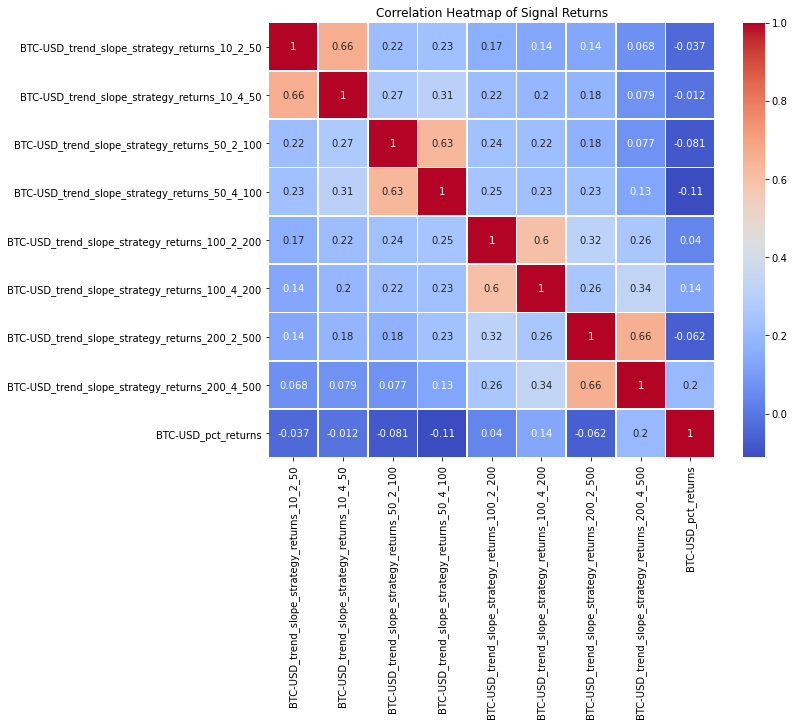

In [426]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(mavg_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Signal Returns')
plt.show()

In [329]:
df_results_returns_t_cost.index.names = ['strategy']
df_results_returns_t_cost[df_results_returns_t_cost.index.get_level_values('strategy').str.startswith('BTC-USD')].sort_values('annualized_sharpe_ratio', ascending=False)

annualized_return  \
strategy                                                            
BTC-USD_10-50-2_trend_slope_strategy_returns            27.080218   
BTC-USD_10-50-4_trend_slope_strategy_returns             5.138555   
BTC-USD_50-100-2_trend_slope_strategy_returns            2.681354   
BTC-USD_200-500-2_trend_slope_strategy_returns           1.510838   
BTC-USD_100-200-2_trend_slope_strategy_returns           1.824680   
BTC-USD_200-500-4_trend_slope_strategy_returns           0.892869   
BTC-USD_50-100-4_trend_slope_strategy_returns            1.642692   
BTC-USD_100-200-4_trend_slope_strategy_returns           1.032979   
BTC-USD_200-500-2_trend_strategy_returns                 0.803306   
BTC-USD_200-500-4_trend_strategy_returns                 0.730178   
BTC-USD_100-200-2_trend_strategy_returns                 0.646168   
BTC-USD_100-200-4_trend_strategy_returns                 0.430003   
BTC-USD_50-100-4_trend_strategy_returns                  0.371330   
BTC-USD_50-100-2_trend_strategy_returns                  0.271022   
BTC-USD_10-50-4_trend_strategy_returns                   0.566427   
BTC-USD_10-50-2_trend_strategy_returns                   0.451595   

                                                annualized_sharpe_ratio  \
strategy                                                                  
BTC-USD_10-50-2_trend_slope_strategy_returns                   3.228045   
BTC-USD_10-50-4_trend_slope_strategy_returns                   2.505997   
BTC-USD_50-100-2_trend_slope_strategy_returns                  1.369340   
BTC-USD_200-500-2_trend_slope_strategy_returns                 1.279522   
BTC-USD_100-200-2_trend_slope_strategy_returns                 1.262361   
BTC-USD_200-500-4_trend_slope_strategy_returns                 1.133989   
BTC-USD_50-100-4_trend_slope_strategy_returns                  1.003418   
BTC-USD_100-200-4_trend_slope_strategy_returns                 0.992784   
BTC-USD_200-500-2_trend_strategy_returns                       0.914135   
BTC-USD_200-500-4_trend_strategy_returns                       0.816383   
BTC-USD_100-200-2_trend_strategy_returns                       0.521189   
BTC-USD_100-200-4_trend_strategy_returns                       0.248515   
BTC-USD_50-100-4_trend_strategy_returns                       -0.041795   
BTC-USD_50-100-2_trend_strategy_returns                       -0.143084   
BTC-USD_10-50-4_trend_strategy_returns                        -0.730539   
BTC-USD_10-50-2_trend_strategy_returns                        -0.990895   

                                                annualized_std_dev  \
strategy                                                             
BTC-USD_10-50-2_trend_slope_strategy_returns              0.660348   
BTC-USD_10-50-4_trend_slope_strategy_returns              0.463304   
BTC-USD_50-100-2_trend_slope_strategy_returns             0.687862   
BTC-USD_200-500-2_trend_slope_strategy_returns            0.692521   
BTC-USD_100-200-2_trend_slope_strategy_returns            0.680503   
BTC-USD_200-500-4_trend_slope_strategy_returns            0.462335   
BTC-USD_50-100-4_trend_slope_strategy_returns             0.448870   
BTC-USD_100-200-4_trend_slope_strategy_returns            0.405730   
BTC-USD_200-500-2_trend_strategy_returns                  0.701882   
BTC-USD_200-500-4_trend_strategy_returns                  0.658656   
BTC-USD_100-200-2_trend_strategy_returns                  0.694487   
BTC-USD_100-200-4_trend_strategy_returns                  0.653925   
BTC-USD_50-100-4_trend_strategy_returns                   0.667740   
BTC-USD_50-100-2_trend_strategy_returns                   0.707828   
BTC-USD_10-50-4_trend_strategy_returns                    0.612883   
BTC-USD_10-50-2_trend_strategy_returns                    0.712933   

                                                max_drawdown  \
strategy                                                       
BTC-USD_10-50-2_trend_slope_strategy_returns       -1.149698   
B

In [ ]:
data[f'{ticker}_trend_strategy_trades'] = data[f'{ticker}_trend_signal'].diff()
data[f'{ticker}_trend_slope_strategy_trades'] = data[f'{ticker}_trend_slope_signal'].diff()

In [ ]:
df_tsla = get_close_prices(start_date, end_date, ticker='TSLA')

In [ ]:
df_tsla.head()

In [ ]:
len(ticker)

In [ ]:
data.head(10)

In [ ]:
ticker = ['SPY']
data_SPY = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data_SPY.head(10)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 21)
ticker = ['PL=F']
data = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [180]:
mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
mavg_start_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
# def get_mavg_windows_trim():
#     mavg_list = []
#     _mavg = []
#     mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
#     mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
#     for i in np.arange(0,10,1):
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
#     mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
#     return mavg_list

In [29]:
def get_mavg_windows():
    mavg_list = []
    _mavg = []
    mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
    mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    for i in np.arange(0,10,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [330]:
def get_mavg_windows_trim():
    mavg_list = []
    _mavg = []
#     mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
#     mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    mavg_start_list = [10, 50, 100, 200]
    mavg_end_list = [50, 100, 200, 500]
#     mavg_stepsize_list = [2,4]
    for i in np.arange(0,4,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [331]:
get_mavg_windows_trim()

[[10, 50, 2],
 [10, 50, 4],
 [50, 100, 2],
 [50, 100, 4],
 [100, 200, 2],
 [100, 200, 4],
 [200, 500, 2],
 [200, 500, 4]]

In [332]:
def get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='simple', price_or_returns_calc='price', annual_trading_days=252, include_transaction_costs_and_fees=True,
                                 transaction_cost_est=0.001, passive_trade_rate=0.5):
    if isinstance(ticker_list, str):
        ticker_list = [ticker_list]
#     mavg_list = get_mavg_windows()
    mavg_list = get_mavg_windows_trim()
    performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown',
                           'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    final_perf_stats = []
    
    for ticker in ticker_list:
        print(ticker)
        df_temp_results = pd.DataFrame(columns=performance_columns)
        for mavg_start, mavg_end, mavg_stepsize in mavg_list:
            print(mavg_start, mavg_end, mavg_stepsize)
            df = get_close_prices(start_date, end_date, ticker)
            df = create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc)
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_strategy_returns'] != 0).any()):
                trend_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_strategy_returns',
                                                                      strategy_trade_count_col=f'{ticker}_trend_strategy_trades',annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
                trend_slope_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns',
                                                                            strategy_trade_count_col=f'{ticker}_trend_slope_strategy_trades', annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_slope_metrics
        final_perf_stats.append(df_temp_results)

    df_results = pd.concat(final_perf_stats, axis=0)
    
    return df_results

In [333]:
ticker_list = ['ETH-USD','SOL-USD','XRP-USD','ADA-USD','DOT-USD','BTC-USD']
df_results_returns_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=True)
df_results_returns_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=False)
df_results_price_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=True)
df_results_price_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=False)

ETH-USD
10 50 2
File data found...reading ['ETH-USD'] data
10 50 4
File data found...reading ['ETH-USD'] data
50 100 2
File data found...reading ['ETH-USD'] data
50 100 4
File data found...reading ['ETH-USD'] data
100 200 2
File data found...reading ['ETH-USD'] data
100 200 4
File data found...reading ['ETH-USD'] data
200 500 2
File data found...reading ['ETH-USD'] data
200 500 4
File data found...reading ['ETH-USD'] data
SOL-USD
10 50 2
File data found...reading ['SOL-USD'] data
10 50 4
File data found...reading ['SOL-USD'] data
50 100 2
File data found...reading ['SOL-USD'] data
50 100 4
File data found...reading ['SOL-USD'] data
100 200 2
File data found...reading ['SOL-USD'] data
100 200 4
File data found...reading ['SOL-USD'] data
200 500 2
File data found...reading ['SOL-USD'] data
200 500 4
File data found...reading ['SOL-USD'] data
XRP-USD
10 50 2
File data found...reading ['XRP-USD'] data
10 50 4
File data found...reading ['XRP-USD'] data
50 100 2
File data found...reading ['X

50 100 4
File data found...reading ['SOL-USD'] data
100 200 2
File data found...reading ['SOL-USD'] data
100 200 4
File data found...reading ['SOL-USD'] data
200 500 2
File data found...reading ['SOL-USD'] data
200 500 4
File data found...reading ['SOL-USD'] data
XRP-USD
10 50 2
File data found...reading ['XRP-USD'] data
10 50 4
File data found...reading ['XRP-USD'] data
50 100 2
File data found...reading ['XRP-USD'] data
50 100 4
File data found...reading ['XRP-USD'] data
100 200 2
File data found...reading ['XRP-USD'] data
100 200 4
File data found...reading ['XRP-USD'] data
200 500 2
File data found...reading ['XRP-USD'] data
200 500 4
File data found...reading ['XRP-USD'] data
ADA-USD
10 50 2
File data found...reading ['ADA-USD'] data
10 50 4
File data found...reading ['ADA-USD'] data
50 100 2
File data found...reading ['ADA-USD'] data
50 100 4
File data found...reading ['ADA-USD'] data
100 200 2
File data found...reading ['ADA-USD'] data
100 200 4
File data found...reading ['ADA-U

In [334]:
df_results_returns_t_cost.sort_values('annualized_sharpe_ratio', ascending=False)

annualized_return  \
SOL-USD_10-50-2_trend_slope_strategy_returns           693.025159   
DOT-USD_10-50-2_trend_slope_strategy_returns           160.492023   
ETH-USD_10-50-2_trend_slope_strategy_returns            71.446784   
ADA-USD_10-50-2_trend_slope_strategy_returns           113.636647   
SOL-USD_10-50-4_trend_slope_strategy_returns            41.659861   
DOT-USD_10-50-4_trend_slope_strategy_returns            16.063362   
XRP-USD_10-50-2_trend_slope_strategy_returns            80.602675   
BTC-USD_10-50-2_trend_slope_strategy_returns            27.080218   
ADA-USD_10-50-4_trend_slope_strategy_returns            13.425775   
XRP-USD_10-50-4_trend_slope_strategy_returns            15.745097   
ETH-USD_10-50-4_trend_slope_strategy_returns             7.570729   
BTC-USD_10-50-4_trend_slope_strategy_returns             5.138555   
SOL-USD_50-100-4_trend_slope_strategy_returns            8.638231   
SOL-USD_50-100-2_trend_slope_strategy_returns            6.408303   
XRP-USD_50-100-2_trend_slope_strategy_returns            5.497127   
ETH-USD_50-100-2_trend_slope_strategy_returns            4.256028   
ADA-USD_50-100-2_trend_slope_strategy_returns            5.221251   
DOT-USD_50-100-2_trend_slope_strategy_returns            5.002338   
BTC-USD_50-100-2_trend_slope_strategy_returns            2.681354   
BTC-USD_200-500-2_trend_slope_strategy_returns           1.510838   
BTC-USD_100-200-2_trend_slope_strategy_returns           1.824680   
DOT-USD_100-200-2_trend_slope_strategy_returns           1.872019   
XRP-USD_200-500-4_trend_slope_strategy_returns           1.759805   
BTC-USD_200-500-4_trend_slope_strategy_returns           0.892869   
ADA-USD_100-200-2_trend_slope_strategy_returns           1.570333   
ETH-USD_200-500-2_trend_slope_strategy_returns           1.335057   
ETH-USD_100-200-2_trend_slope_strategy_returns           1.938093   
XRP-USD_50-100-4_trend_slope_strategy_returns            1.834031   
SOL-USD_200-500-2_trend_slope_strategy_returns           1.115985   
SOL-USD_200-500-4_trend_slope_strategy_returns           0.980154   
SOL-USD_200-500-4_trend_strategy_returns                 1.125209   
BTC-USD_50-100-4_trend_slope_strategy_returns            1.642692   
ADA-USD_50-100-4_trend_slope_strategy_returns            1.636356   
BTC-USD_100-200-4_trend_slope_strategy_returns           1.032979   
DOT-USD_100-200-4_trend_slope_strategy_returns           1.136664   
ADA-USD_200-500-4_trend_strategy_returns                 0.920469   
DOT-USD_50-100-4_trend_slope_strategy_returns            1.648049   
BTC-USD_200-500-2_trend_strategy_returns                 0.803306   
ADA-USD_200-500-2_trend_slope_strategy_returns           0.949503   
XRP-USD_200-500-2_trend_slope_strategy_returns           1.042567   
SOL-USD_100-200-2_trend_slope_strategy_returns           0.720222   
BTC-USD_200-500-4_trend_strategy_returns                 0.730178   
ETH-USD_50-100-4_trend_slope_strategy_returns            1.463457   
ADA-USD_100-200-4_trend_slope_strategy_returns           0.982317   
SOL-USD_100-200-2_trend_strategy_returns                 0.492207   
SOL-USD_50-100-2_trend_strategy_returns                  0.845201   
SOL-USD_200-500-2_trend_strategy_returns                 0.493234   
ETH-USD_200-500-4_trend_slope_strategy_returns           0.640868   
SOL-USD_100-200-4_trend_strategy_returns                 0.478425   
XRP-USD_100-200-2_trend_slope_strategy_returns           1.023874   
XRP-USD_100-200-4_trend_slope_strategy_returns           0.716224   
SOL-USD_50-100-4_trend_strategy_returns                  0.576121   
ADA-USD_200-500-2_trend_strategy_returns                 0.421241   
SOL-USD_100-200-4_trend_slope_strategy_returns           0.550479   
BTC-USD_100-200-2_trend_strategy_returns                 0.646168   
ETH-USD_100-200-4_trend_slope_strategy_returns           0.706777   
ADA-USD_200-500-4_trend_slope_strategy_returns           0.346545   
DOT-USD_200-500-4_trend_strategy_returns      

In [336]:
df_results_price_t_cost.sort_values('annualized_sharpe_ratio', ascending=False)

annualized_return  \
SOL-USD_10-50-2_trend_slope_strategy_returns             4.300409   
SOL-USD_10-50-4_trend_slope_strategy_returns             3.021616   
SOL-USD_100-200-4_trend_strategy_returns                 2.086533   
ADA-USD_10-50-2_trend_slope_strategy_returns             2.710486   
SOL-USD_10-50-4_trend_strategy_returns                   2.085463   
ETH-USD_10-50-2_trend_slope_strategy_returns             2.345696   
ADA-USD_10-50-4_trend_slope_strategy_returns             1.760727   
XRP-USD_10-50-2_trend_slope_strategy_returns             2.333833   
XRP-USD_10-50-4_trend_slope_strategy_returns             1.496035   
SOL-USD_10-50-2_trend_strategy_returns                   1.562346   
DOT-USD_10-50-2_trend_slope_strategy_returns             2.026661   
SOL-USD_200-500-2_trend_slope_strategy_returns           1.141654   
SOL-USD_200-500-4_trend_slope_strategy_returns           1.050863   
SOL-USD_100-200-2_trend_strategy_returns                 1.101342   
BTC-USD_10-50-2_trend_slope_strategy_returns             1.560443   
SOL-USD_50-100-4_trend_strategy_returns                  1.098457   
SOL-USD_100-200-4_trend_slope_strategy_returns           1.081346   
ADA-USD_200-500-4_trend_slope_strategy_returns           0.948834   
ETH-USD_200-500-4_trend_slope_strategy_returns           0.799888   
SOL-USD_50-100-2_trend_strategy_returns                  0.856492   
ETH-USD_100-200-2_trend_slope_strategy_returns           0.765822   
BTC-USD_10-50-4_trend_slope_strategy_returns             0.936012   
BTC-USD_200-500-4_trend_slope_strategy_returns           0.594462   
ADA-USD_10-50-2_trend_strategy_returns                   0.902033   
DOT-USD_10-50-4_trend_strategy_returns                   0.889174   
BTC-USD_100-200-4_trend_slope_strategy_returns           0.578537   
ADA-USD_10-50-4_trend_strategy_returns                   0.783065   
SOL-USD_50-100-4_trend_slope_strategy_returns            0.585833   
ADA-USD_200-500-2_trend_slope_strategy_returns           0.502770   
BTC-USD_200-500-2_trend_slope_strategy_returns           0.489430   
DOT-USD_200-500-4_trend_slope_strategy_returns           0.453583   
BTC-USD_50-100-2_trend_strategy_returns                  0.487882   
DOT-USD_50-100-2_trend_strategy_returns                  0.440416   
DOT-USD_50-100-4_trend_strategy_returns                  0.470652   
BTC-USD_50-100-4_trend_strategy_returns                  0.434740   
ADA-USD_100-200-4_trend_slope_strategy_returns           0.436551   
BTC-USD_200-500-4_trend_strategy_returns                 0.385093   
DOT-USD_10-50-2_trend_strategy_returns                   0.490611   
ETH-USD_200-500-2_trend_slope_strategy_returns           0.348871   
BTC-USD_10-50-4_trend_strategy_returns                   0.552500   
SOL-USD_100-200-2_trend_slope_strategy_returns           0.167190   
ETH-USD_100-200-4_trend_slope_strategy_returns           0.395301   
DOT-USD_10-50-4_trend_slope_strategy_returns             0.617865   
ADA-USD_100-200-2_trend_slope_strategy_returns           0.318043   
ADA-USD_100-200-2_trend_strategy_returns                 0.267460   
BTC-USD_100-200-2_trend_slope_strategy_returns           0.367270   
BTC-USD_100-200-4_trend_strategy_returns                 0.321191   
BTC-USD_100-200-2_trend_strategy_returns                 0.320881   
DOT-USD_50-100-4_trend_slope_strategy_returns            0.328846   
BTC-USD_200-500-2_trend_strategy_returns                 0.273749   
ETH-USD_10-50-4_trend_strategy_returns                   0.451692   
SOL-USD_50-100-2_trend_slope_strategy_returns           -0.015830   
ADA-USD_50-100-4_trend_strategy_returns                  0.213502   
ETH-USD_10-50-4_trend_slope_strategy_returns             0.584957   
BTC-USD_10-50-2_trend_strategy_returns                   0.390493   
ETH-USD_50-100-2_trend_strategy_returns                  0.177568   
ADA-USD_100-200-4_trend_strategy_returns                 0.127207   
XRP-USD_200-500-2_trend_slope_strategy_returns

In [274]:
df_results_returns_no_t_cost

annualized_return  \
ETH-USD_10-50-2_trend_strategy_returns                  -0.041614   
ETH-USD_10-50-2_trend_slope_strategy_returns            71.446784   
ETH-USD_10-50-4_trend_strategy_returns                   0.297199   
ETH-USD_10-50-4_trend_slope_strategy_returns             7.570734   
ETH-USD_50-100-2_trend_strategy_returns                  0.372492   
ETH-USD_50-100-2_trend_slope_strategy_returns            4.256087   
ETH-USD_50-100-4_trend_strategy_returns                  0.346230   
ETH-USD_50-100-4_trend_slope_strategy_returns            1.467598   
ETH-USD_100-200-2_trend_strategy_returns                 0.130815   
ETH-USD_100-200-2_trend_slope_strategy_returns           1.939951   
ETH-USD_100-200-4_trend_strategy_returns                 0.078054   
ETH-USD_100-200-4_trend_slope_strategy_returns           0.728979   
ETH-USD_200-500-2_trend_strategy_returns                -0.038887   
ETH-USD_200-500-2_trend_slope_strategy_returns           1.341197   
ETH-USD_200-500-4_trend_strategy_returns                -0.003541   
ETH-USD_200-500-4_trend_slope_strategy_returns           0.668747   
SOL-USD_10-50-2_trend_strategy_returns                  -0.214718   
SOL-USD_10-50-2_trend_slope_strategy_returns           693.025159   
SOL-USD_10-50-4_trend_strategy_returns                   0.604469   
SOL-USD_10-50-4_trend_slope_strategy_returns            41.659867   
SOL-USD_50-100-2_trend_strategy_returns                  0.924924   
SOL-USD_50-100-2_trend_slope_strategy_returns            6.409371   
SOL-USD_50-100-4_trend_strategy_returns                  0.698259   
SOL-USD_50-100-4_trend_slope_strategy_returns            8.638914   
SOL-USD_100-200-2_trend_strategy_returns                 0.583060   
SOL-USD_100-200-2_trend_slope_strategy_returns           0.776593   
SOL-USD_100-200-4_trend_strategy_returns                 0.578222   
SOL-USD_100-200-4_trend_slope_strategy_returns           0.642620   
SOL-USD_200-500-2_trend_strategy_returns                 0.606822   
SOL-USD_200-500-2_trend_slope_strategy_returns           1.154371   
SOL-USD_200-500-4_trend_strategy_returns                 1.167855   
SOL-USD_200-500-4_trend_slope_strategy_returns           1.022774   
XRP-USD_10-50-2_trend_strategy_returns                   0.455009   
XRP-USD_10-50-2_trend_slope_strategy_returns            80.602675   
XRP-USD_10-50-4_trend_strategy_returns                   0.617249   
XRP-USD_10-50-4_trend_slope_strategy_returns            15.745098   
XRP-USD_50-100-2_trend_strategy_returns                 -0.336332   
XRP-USD_50-100-2_trend_slope_strategy_returns            5.497145   
XRP-USD_50-100-4_trend_strategy_returns                 -0.208350   
XRP-USD_50-100-4_trend_slope_strategy_returns            1.835675   
XRP-USD_100-200-2_trend_strategy_returns                -0.629944   
XRP-USD_100-200-2_trend_slope_strategy_returns           1.036899   
XRP-USD_100-200-4_trend_strategy_returns                -0.566972   
XRP-USD_100-200-4_trend_slope_strategy_returns           0.734008   
XRP-USD_200-500-2_trend_strategy_returns                -0.601554   
XRP-USD_200-500-2_trend_slope_strategy_returns           1.054312   
XRP-USD_200-500-4_trend_strategy_returns                -0.378270   
XRP-USD_200-500-4_trend_slope_strategy_returns           1.763338   
ADA-USD_10-50-2_trend_strategy_returns                   0.405379   
ADA-USD_10-50-2_trend_slope_strategy_returns           113.636647   
ADA-USD_10-50-4_trend_strategy_returns                   0.415271   
ADA-USD_10-50-4_trend_slope_strategy_returns            13.425775   
ADA-USD_50-100-2_trend_strategy_returns                  0.089528   
ADA-USD_50-100-2_trend_slope_strategy_returns            5.221278   
ADA-USD_50-100-4_trend_strategy_returns                  0.322510   
ADA-USD_50-100-4_trend_slope_strategy_returns            1.638877   
ADA-USD_100-200-2_trend_strategy_returns                 0.375803   
ADA-USD_100-200-2_trend_slope_strategy_returns

In [275]:
df_results_price_no_t_cost

annualized_return  \
ETH-USD_10-50-2_trend_strategy_returns                   0.220298   
ETH-USD_10-50-2_trend_slope_strategy_returns             2.346123   
ETH-USD_10-50-4_trend_strategy_returns                   0.470264   
ETH-USD_10-50-4_trend_slope_strategy_returns             0.604159   
ETH-USD_50-100-2_trend_strategy_returns                  0.192300   
ETH-USD_50-100-2_trend_slope_strategy_returns           -0.088472   
ETH-USD_50-100-4_trend_strategy_returns                  0.174261   
ETH-USD_50-100-4_trend_slope_strategy_returns           -0.293704   
ETH-USD_100-200-2_trend_strategy_returns                -0.019665   
ETH-USD_100-200-2_trend_slope_strategy_returns           0.767603   
ETH-USD_100-200-4_trend_strategy_returns                 0.016656   
ETH-USD_100-200-4_trend_slope_strategy_returns           0.404364   
ETH-USD_200-500-2_trend_strategy_returns                -0.303496   
ETH-USD_200-500-2_trend_slope_strategy_returns           0.352395   
ETH-USD_200-500-4_trend_strategy_returns                -0.087462   
ETH-USD_200-500-4_trend_slope_strategy_returns           0.802329   
SOL-USD_10-50-2_trend_strategy_returns                   1.570300   
SOL-USD_10-50-2_trend_slope_strategy_returns             4.302061   
SOL-USD_10-50-4_trend_strategy_returns                   2.090287   
SOL-USD_10-50-4_trend_slope_strategy_returns             3.024655   
SOL-USD_50-100-2_trend_strategy_returns                  0.865517   
SOL-USD_50-100-2_trend_slope_strategy_returns            0.080668   
SOL-USD_50-100-4_trend_strategy_returns                  1.103660   
SOL-USD_50-100-4_trend_slope_strategy_returns            0.610313   
SOL-USD_100-200-2_trend_strategy_returns                 1.104073   
SOL-USD_100-200-2_trend_slope_strategy_returns           0.192444   
SOL-USD_100-200-4_trend_strategy_returns                 2.087479   
SOL-USD_100-200-4_trend_slope_strategy_returns           1.086943   
SOL-USD_200-500-2_trend_strategy_returns                -0.499617   
SOL-USD_200-500-2_trend_slope_strategy_returns           1.145529   
SOL-USD_200-500-4_trend_strategy_returns                -0.484088   
SOL-USD_200-500-4_trend_slope_strategy_returns           1.055077   
XRP-USD_10-50-2_trend_strategy_returns                  -0.527469   
XRP-USD_10-50-2_trend_slope_strategy_returns             2.334217   
XRP-USD_10-50-4_trend_strategy_returns                  -0.507131   
XRP-USD_10-50-4_trend_slope_strategy_returns             1.497373   
XRP-USD_50-100-2_trend_strategy_returns                 -0.590590   
XRP-USD_50-100-2_trend_slope_strategy_returns           -0.379086   
XRP-USD_50-100-4_trend_strategy_returns                 -0.474488   
XRP-USD_50-100-4_trend_slope_strategy_returns           -0.370487   
XRP-USD_100-200-2_trend_strategy_returns                -0.201545   
XRP-USD_100-200-2_trend_slope_strategy_returns          -0.448340   
XRP-USD_100-200-4_trend_strategy_returns                -0.240359   
XRP-USD_100-200-4_trend_slope_strategy_returns          -0.350216   
XRP-USD_200-500-2_trend_strategy_returns                -0.623789   
XRP-USD_200-500-2_trend_slope_strategy_returns           0.072218   
XRP-USD_200-500-4_trend_strategy_returns                -0.517114   
XRP-USD_200-500-4_trend_slope_strategy_returns           0.082174   
ADA-USD_10-50-2_trend_strategy_returns                   0.905597   
ADA-USD_10-50-2_trend_slope_strategy_returns             2.710700   
ADA-USD_10-50-4_trend_strategy_returns                   0.788341   
ADA-USD_10-50-4_trend_slope_strategy_returns             1.761505   
ADA-USD_50-100-2_trend_strategy_returns                  0.092928   
ADA-USD_50-100-2_trend_slope_strategy_returns           -0.321564   
ADA-USD_50-100-4_trend_strategy_returns                  0.228109   
ADA-USD_50-100-4_trend_slope_strategy_returns           -0.073820   
ADA-USD_100-200-2_trend_strategy_returns                 0.273081   
ADA-USD_100-200-2_trend_slope_strategy_returns

## Rolling Sharpe Ratio

In [379]:
def rolling_sharpe_ratio(df, window, strategy_daily_return_col, strategy_trade_count_col, **kwargs):
    def sharpe_on_window(window_df):
        # Calculate the Sharpe ratio on the windowed data frame
        return sharpe_ratio(window_df, strategy_daily_return_col, strategy_trade_count_col, **kwargs)

    # Apply the function over a rolling window and return as a Series (not a full DataFrame)
    rolling_sharpe = df[strategy_daily_return_col].rolling(window=window).apply(
        lambda x: sharpe_on_window(df.loc[x.index]), raw=False
    )
    
    # Add the rolling Sharpe ratio as a new column in the original DataFrame
    df[f'rolling_sharpe_{window}'] = rolling_sharpe
    
    return df

In [380]:
# short_mavg_window = [10,20,10,20,30,30,40,50,100,90]
# long_mavg_window = [100,200,100,200,300,300,400,500,1000,900]
short_mavg_window = [10, 50, 100, 200]
long_mavg_window = [50, 100, 200, 500]
mavg_stepsize_list = [2,4]

In [381]:
print(len(short_mavg_window))
print(len(long_mavg_window))
print(len(mavg_stepsize_list))

4
4
2


In [399]:
# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame with the date_range as the index
df_returns = pd.DataFrame(index=date_range)

In [400]:
ticker = 'BTC-USD'
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)

for i in np.arange(0,4):
    print(i)
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
#         print(mavg_stepsize)
#         mavg_stepsize = mavg_stepsize_list[i]
        data = get_close_prices(start_date, end_date, ticker)
        data = (create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')
                .rename(columns={'BTC-USD_trend_slope_strategy_returns': f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}',
                                 'BTC-USD_trend_slope_strategy_trades': f'BTC-USD_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}'}))
        df_returns = pd.merge(df_returns, data[[f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}', f'BTC-USD_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}']],
                              left_index=True, right_index=True, how='left')

df_returns = df_returns.dropna()

0
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
1
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
2
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
3
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data


In [401]:
df_returns.shape

(3104, 16)

In [402]:
df_returns.tail(200)

BTC-USD_trend_slope_strategy_returns_10_2_50  \
2024-01-13                                      0.000252   
2024-01-14                                      0.024418   
2024-01-15                                     -0.017124   
2024-01-16                                     -0.015125   
2024-01-17                                      0.009554   
2024-01-18                                      0.034640   
2024-01-19                                     -0.008636   
2024-01-20                                     -0.001134   
2024-01-21                                      0.002875   
2024-01-22                                      0.049064   
2024-01-23                                      0.008560   
2024-01-24                                      0.005811   
2024-01-25                                     -0.003575   
2024-01-26                                      0.047155   
2024-01-27                                      0.007250   
2024-01-28                                     -0.002005   
2024-01-29                                      0.029800   
2024-01-30                                     -0.007754   
2024-01-31                                     -0.008614   
2024-02-01                                      0.011581   
2024-02-02                                      0.002556   
2024-02-03                                     -0.004483   
2024-02-04                                     -0.009506   
2024-02-05                                     -0.001763   
2024-02-06                                     -0.009986   
2024-02-07                                      0.028631   
2024-02-08                                      0.022188   
2024-02-09                                      0.040741   
2024-02-10                                      0.013237   
2024-02-11                                      0.010940   
2024-02-12                                      0.034462   
2024-02-13                                     -0.004319   
2024-02-14                                      0.041901   
2024-02-15                                      0.002158   
2024-02-16                                      0.004268   
2024-02-17                                     -0.009532   
2024-02-18                                     -0.008895   
2024-02-19                                      0.006588   
2024-02-20                                     -0.009767   
2024-02-21                                      0.008524   
2024-02-22                                      0.010305   
2024-02-23                                      0.011169   
2024-02-24                                     -0.016541   
2024-02-25                                     -0.003144   
2024-02-26                                     -0.053914   
2024-02-27                                      0.047008   
2024-02-28                                      0.094935   
2024-02-29                                     -0.020901   
2024-03-01                                      0.020299   
2024-03-02                                     -0.006579   
2024-03-03                                      0.018338   
2024-03-04                                      0.081736   
2024-03-05                                     -0.066284   
2024-03-06                                      0.036137   
2024-03-07                                      0.012384   
2024-03-08                                     -0.020539   
2024-03-09                                     -0.002911   
2024-03-10                                     -0.007605   
2024-03-11                                     -0.044974   
2024-03-12                                      0.008910   
2024-03-13                                     -0.022414   
2024-03-14                                      0.023082   
2024-03-15                                      0.027912   
2024-03-16                                      0.058911   
2024-03-17                                     -0.047087   
2024-03-18                                      0.01

In [403]:
# # ticker = 'ETH-USD'
# ticker = 'BTC-USD'
# data = get_close_prices(start_date, end_date, ticker)
# mavg_start = 100
# mavg_end = 200
# mavg_stepsize = 4
# data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

In [375]:
# # Example usage:
# window = 180 # 1 year rolling window assuming 252 trading days in a year
# rolling_sharpe = rolling_sharpe_ratio(data, window, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns', strategy_trade_count_col='BTC-USD_trend_slope_strategy_trades')

In [404]:
window = 180
for i in np.arange(0,3):
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
        print(mavg_start, mavg_end, mavg_stepsize)
        df_returns = rolling_sharpe_ratio(df_returns, window, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}',
                                          strategy_trade_count_col=f'{ticker}_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}')
        df_returns = df_returns.rename(columns={f'rolling_sharpe_{window}': f'{ticker}_{mavg_start}_{mavg_stepsize}_{mavg_end}_rolling_{window}_sharpe'})

10 50 2
10 50 4
50 100 2
50 100 4
100 200 2
100 200 4


In [405]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
data[f'{ticker}_pct_returns'] = data[f'{ticker}'].pct_change()
df_returns = pd.merge(df_returns, data, left_index=True, right_index=True, how='left')

File data found...reading ['BTC-USD'] data


In [406]:
data.head()

BTC-USD  BTC-USD_pct_returns
Date                                       
2014-09-17  457.334015                  NaN
2014-09-18  424.440002            -0.071926
2014-09-19  394.795990            -0.069843
2014-09-20  408.903992             0.035735
2014-09-21  398.821014            -0.024659

In [407]:
df_returns.tail()

BTC-USD_trend_slope_strategy_returns_10_2_50  \
2024-07-26                                     -0.032456   
2024-07-27                                      0.001454   
2024-07-28                                     -0.006526   
2024-07-29                                      0.021038   
2024-07-30                                      0.009262   

            BTC-USD_trend_slope_strategy_trades_10_2_50  \
2024-07-26                                          0.0   
2024-07-27                                          0.0   
2024-07-28                                          0.0   
2024-07-29                                          0.0   
2024-07-30                                          0.0   

            BTC-USD_trend_slope_strategy_returns_10_4_50  \
2024-07-26                                           0.0   
2024-07-27                                          -0.0   
2024-07-28                                           0.0   
2024-07-29                                          -0.0   
2024-07-30                                          -0.0   

            BTC-USD_trend_slope_strategy_trades_10_4_50  \
2024-07-26                                          0.0   
2024-07-27                                          0.0   
2024-07-28                                          0.0   
2024-07-29                                          0.0   
2024-07-30                                          0.0   

            BTC-USD_trend_slope_strategy_returns_50_2_100  \
2024-07-26                                       0.032456   
2024-07-27                                      -0.001454   
2024-07-28                                       0.006526   
2024-07-29                                      -0.021038   
2024-07-30                                      -0.009262   

            BTC-USD_trend_slope_strategy_trades_50_2_100  \
2024-07-26                                           2.0   
2024-07-27                                           0.0   
2024-07-28                                           0.0   
2024-07-29                                           0.0   
2024-07-30                                           0.0   

            BTC-USD_trend_slope_strategy_returns_50_4_100  \
2024-07-26                                            0.0   
2024-07-27                                           -0.0   
2024-07-28                                            0.0   
2024-07-29                                           -0.0   
2024-07-30                                           -0.0   

            BTC-USD_trend_slope_strategy_trades_50_4_100  \
2024-07-26                                           0.0   
2024-07-27                                           0.0   
2024-07-28                                           0.0   
2024-07-29                                           0.0   
2024-07-30                                           0.0   

            BTC-USD_trend_slope_strategy_returns_100_2_200  \
2024-07-26                                        0.032456   
2024-07-27                                        0.001454   
2024-07-28                                       -0.006526   
2024-07-29                                        0.021038   
2024-07-30                                        0.009262   

            BTC-USD_trend_slope_strategy_trades_100_2_200  \
2024-07-26                                            2.0   
2024-07-27                                           -2.0   
2024-07-28                                            0.0   
2024-07-29                                            0.0   
2024-07-30                                            0.0   

            BTC-USD_trend_slope_strategy_returns_100_4_200  \
2024-07-26                                             0.0   
2024-07-27                                            -0.0   
2024-07-28                                             0.0   
2024-07-29                                            -0.0   
2024-07-30                                            -0.0   

           

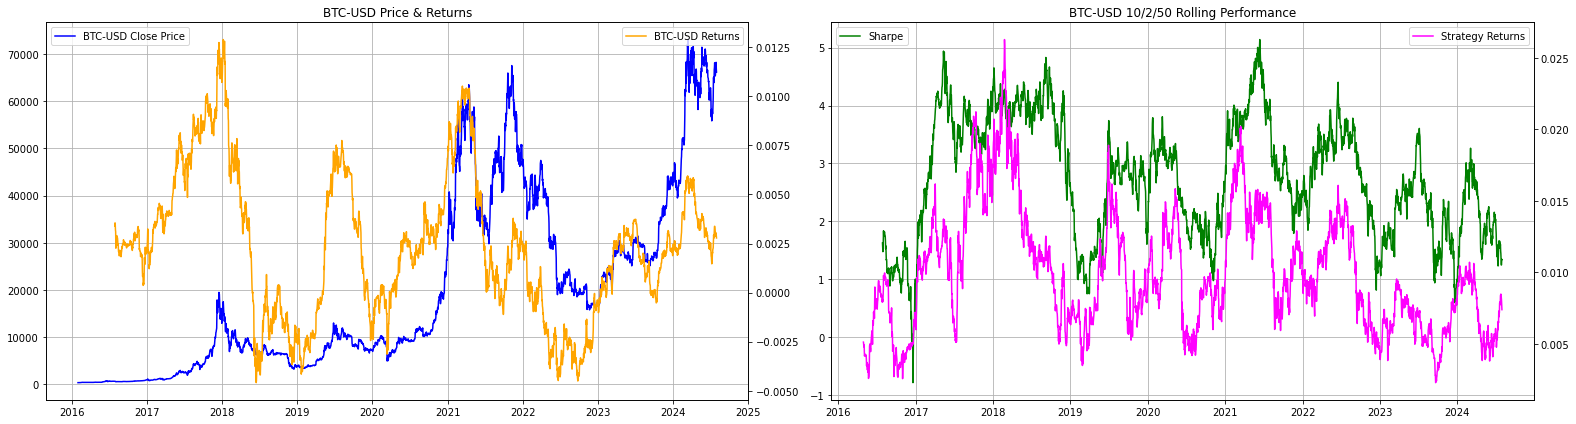

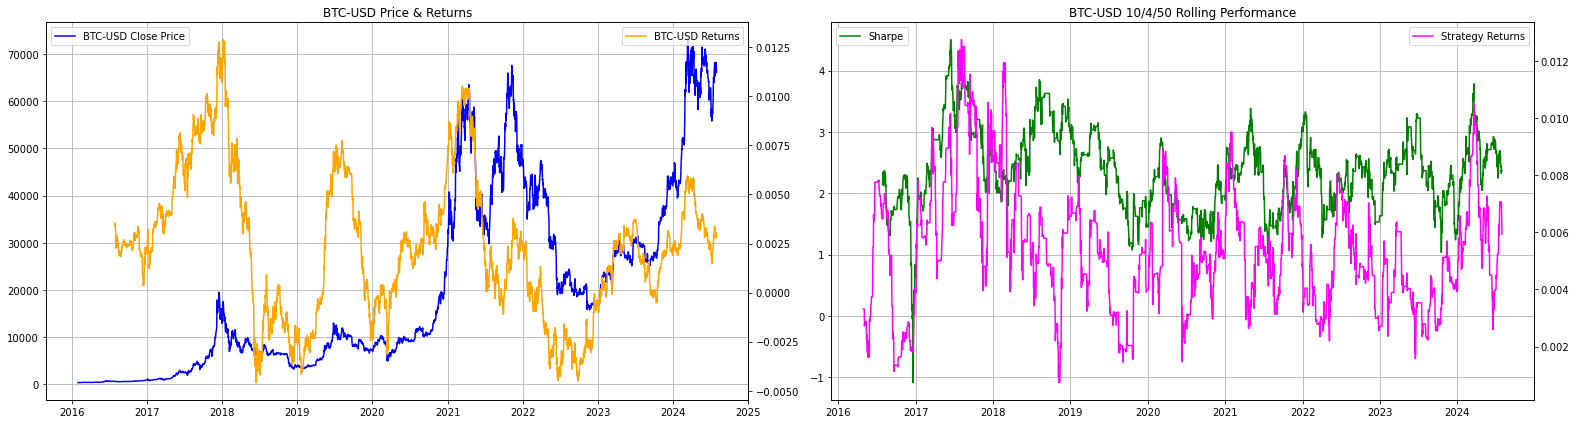

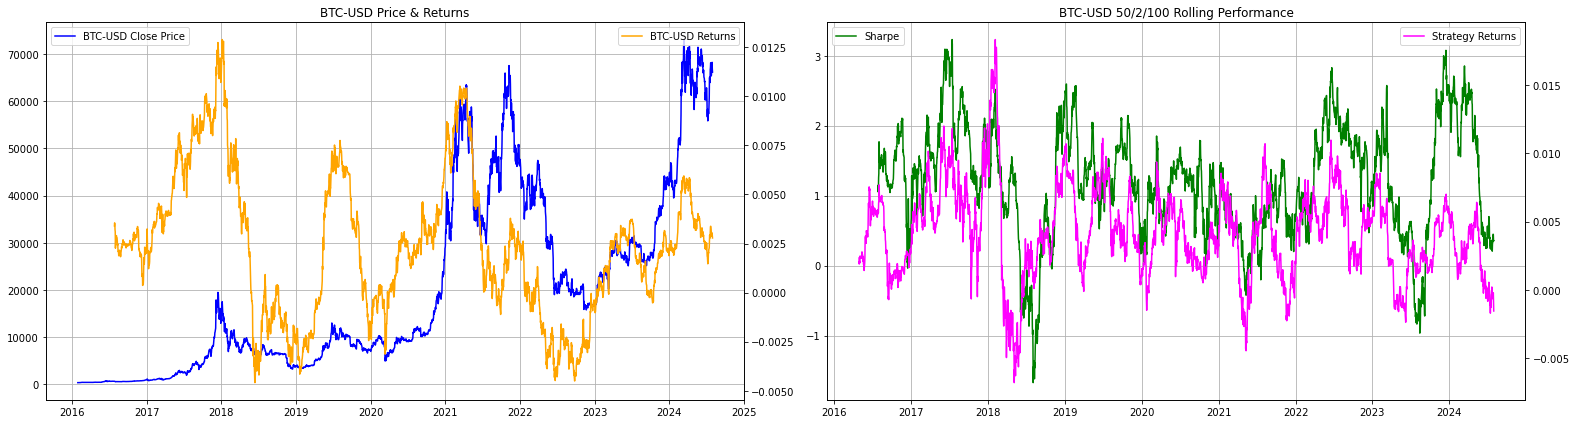

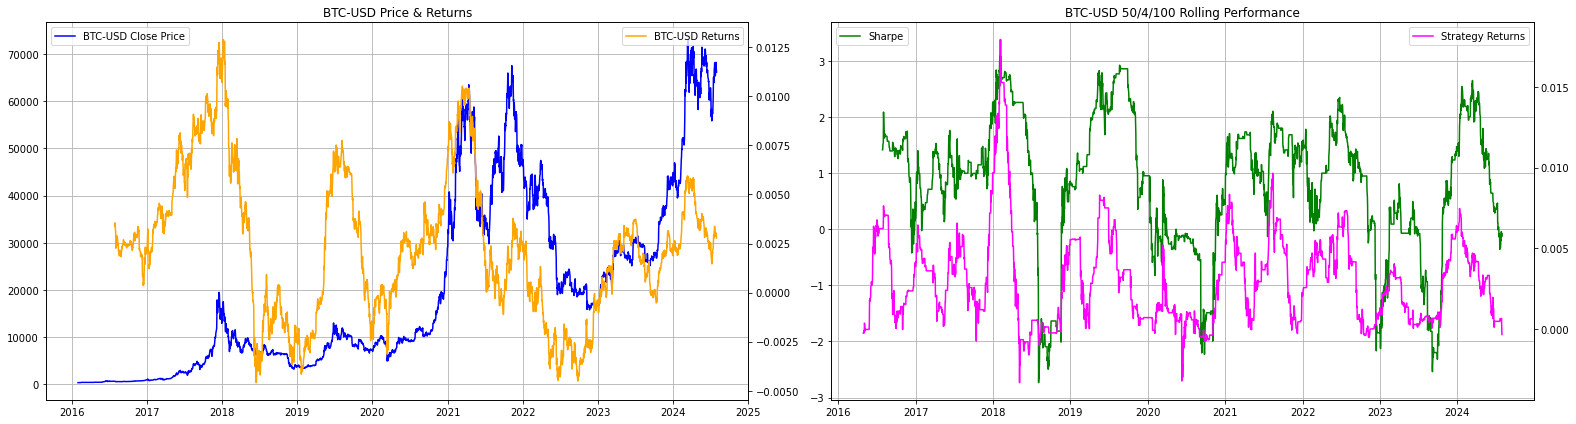

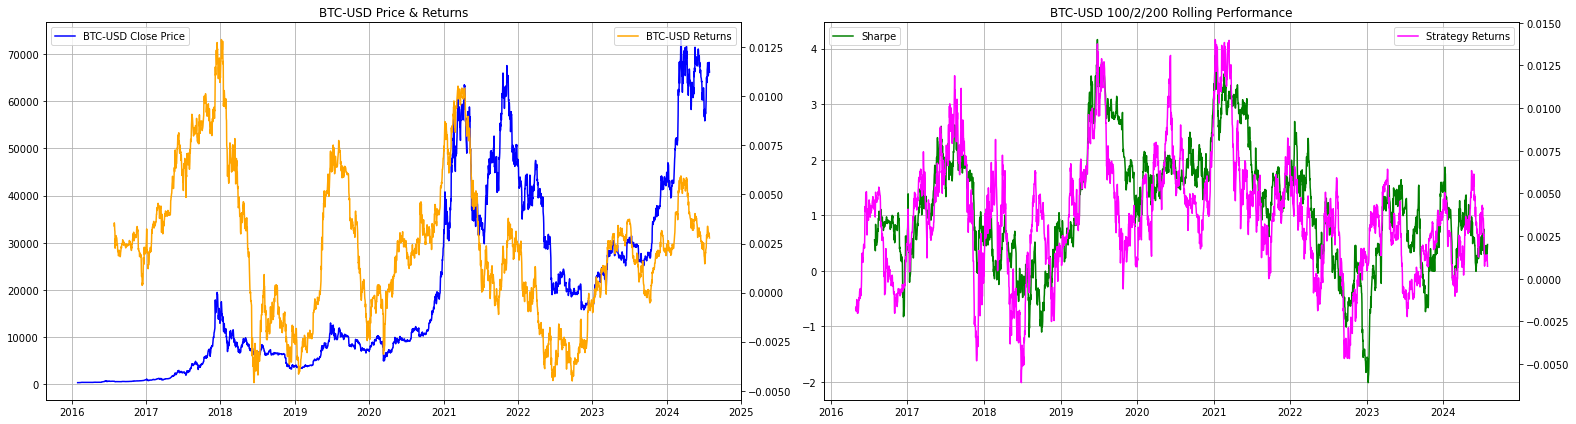

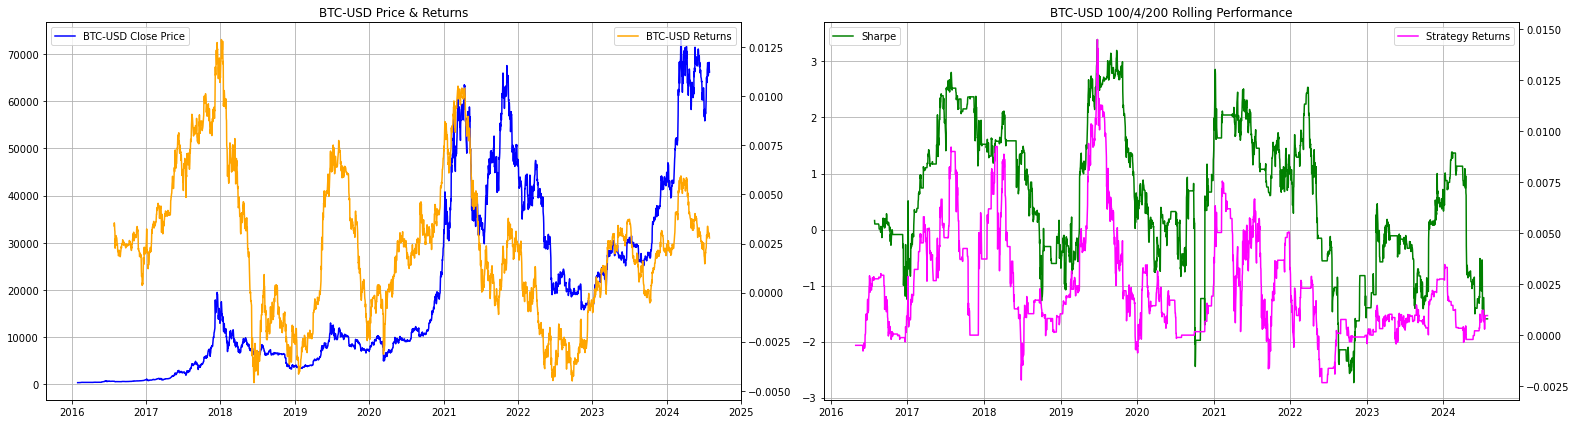

In [412]:
for i in np.arange(0,3):
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
        fig = plt.figure(figsize=(22,6))
        # plt.style.use('bmh')
        layout = (1,2)
        price_return_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        rolling_performance_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        
        _ = price_return_ax.plot(df_returns.index, df_returns[f'{ticker}'], label=f'{ticker} Close Price', color='blue')
        price_return_ax_2 = price_return_ax.twinx()
        _ = price_return_ax_2.plot(df_returns.index, df_returns[f'{ticker}_pct_returns'].rolling(window).mean(), label=f'{ticker} Returns', color='orange')

        _ = rolling_performance_ax.plot(df_returns.index, df_returns[f'{ticker}_{mavg_start}_{mavg_stepsize}_{mavg_end}_rolling_{window}_sharpe'], label=f'Sharpe', color='green')
        rolling_performance_ax_2 = rolling_performance_ax.twinx()
        _ = rolling_performance_ax_2.plot(df_returns.index, df_returns[f'{ticker}_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}'].rolling(90).mean(),
                                          label='Strategy Returns', color='magenta')

        _ = price_return_ax.grid()
        _ = price_return_ax.legend(loc='upper left')
        _ = price_return_ax_2.legend(loc='upper right')
        _ = price_return_ax.set_title(f'{ticker} Price & Returns')
        # _ = rolling_sharpe.grid()
        _ = rolling_performance_ax.legend(loc='upper left')
        _ = rolling_performance_ax.grid()
        _ = rolling_performance_ax_2.legend(loc='upper right')
        _ = rolling_performance_ax_2.set_title(f'{ticker} {mavg_start}/{mavg_stepsize}/{mavg_end} Rolling Performance')
        # _ = momentum_ax_4.grid()
        # _ = momentum_ax_4.legend()
        # _ = momentum_ax_5.grid()
        # _ = momentum_ax_5.legend()
        # _ = momentum_ax_6.grid()
        # _ = momentum_ax_6.legend()

        plt.tight_layout()

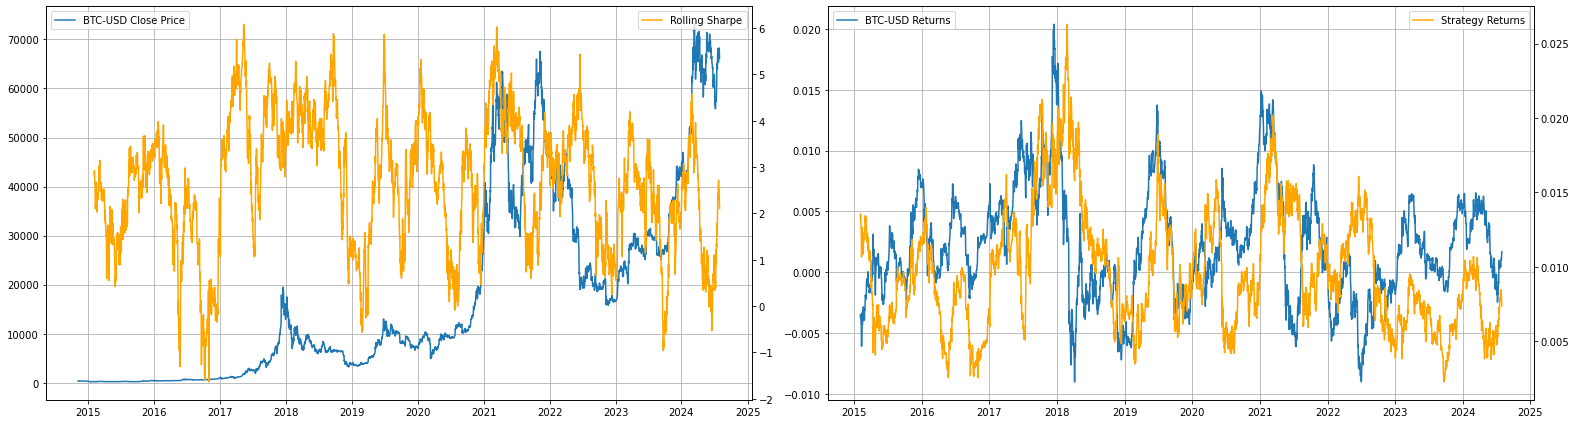

In [301]:
fig = plt.figure(figsize=(22,6))
# plt.style.use('bmh')
layout = (1,2)
rolling_sharpe = plt.subplot2grid(layout, (0,0))#, colspan=2)
returns_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
# momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
# momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

rolling_sharpe_2 = rolling_sharpe.twinx()
_ = rolling_sharpe.plot(data.index, data[f'{ticker}'], label=f'{ticker} Close Price')
_ = rolling_sharpe_2.plot(data.index, data['rolling_sharpe_90'], label='Rolling Sharpe', color='orange')

returns_ax_2 = returns_ax.twinx()
_ = returns_ax.plot(data.index, data[f'{ticker}_pct_returns'].rolling(90).mean(), label=f'{ticker} Returns')
_ = returns_ax_2.plot(data.index, data[f'{ticker}_trend_slope_strategy_returns'].rolling(90).mean(), label='Strategy Returns', color='orange')

# momentum_twin_ax_2 = momentum_ax_2.twinx()
# _ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
# _ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_3 = momentum_ax_3.twinx()
# _ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
# _ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_4 = momentum_ax_4.twinx()
# _ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
# _ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_5 = momentum_ax_5.twinx()
# _ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
# _ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_6 = momentum_ax_6.twinx()
# _ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
# _ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = rolling_sharpe.grid()
_ = rolling_sharpe.legend(loc='upper left')
# _ = rolling_sharpe.grid()
_ = rolling_sharpe_2.legend()
_ = returns_ax.grid()
_ = returns_ax.legend(loc='upper left')
_ = returns_ax_2.legend()
# _ = momentum_ax_4.grid()
# _ = momentum_ax_4.legend()
# _ = momentum_ax_5.grid()
# _ = momentum_ax_5.legend()
# _ = momentum_ax_6.grid()
# _ = momentum_ax_6.legend()

plt.tight_layout()

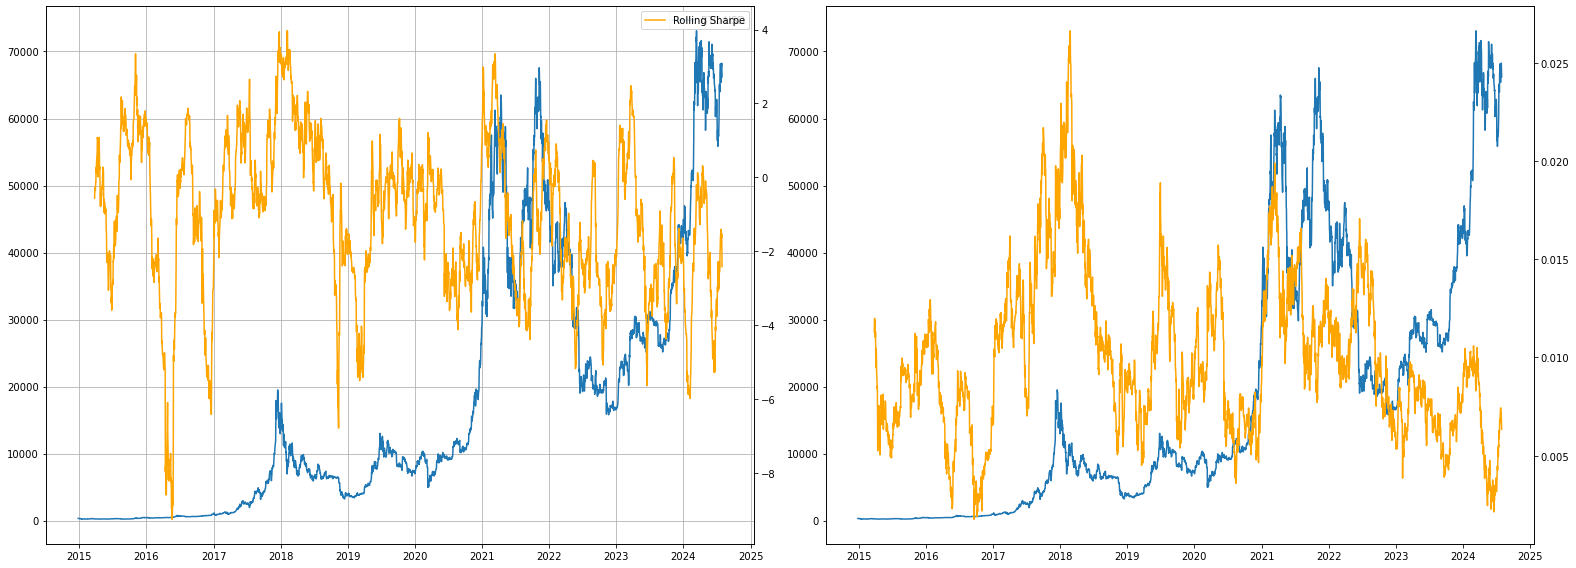

In [170]:
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (1,2)
rolling_sharpe = plt.subplot2grid(layout, (0,0))#, colspan=2)
returns_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
# momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
# momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

rolling_sharpe_2 = rolling_sharpe.twinx()
_ = rolling_sharpe.plot(data.index, data[f'BTC-USD'], label='BTC-USD')
_ = rolling_sharpe_2.plot(data.index, data['rolling_sharpe_90'], label='Rolling Sharpe', color='orange')

returns_ax_2 = returns_ax.twinx()
_ = returns_ax.plot(data.index, data[f'BTC-USD'], label='BTC-USD')
_ = returns_ax_2.plot(data.index, data['BTC-USD_trend_slope_strategy_returns'].rolling(90).mean(), label='Strategy Returns', color='orange')

# momentum_twin_ax_2 = momentum_ax_2.twinx()
# _ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
# _ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_3 = momentum_ax_3.twinx()
# _ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
# _ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_4 = momentum_ax_4.twinx()
# _ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
# _ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_5 = momentum_ax_5.twinx()
# _ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
# _ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_6 = momentum_ax_6.twinx()
# _ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
# _ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = rolling_sharpe.grid()
_ = rolling_sharpe.legend()
# _ = rolling_sharpe.grid()
_ = rolling_sharpe_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
# _ = momentum_ax_4.grid()
# _ = momentum_ax_4.legend()
# _ = momentum_ax_5.grid()
# _ = momentum_ax_5.legend()
# _ = momentum_ax_6.grid()
# _ = momentum_ax_6.legend()

plt.tight_layout()

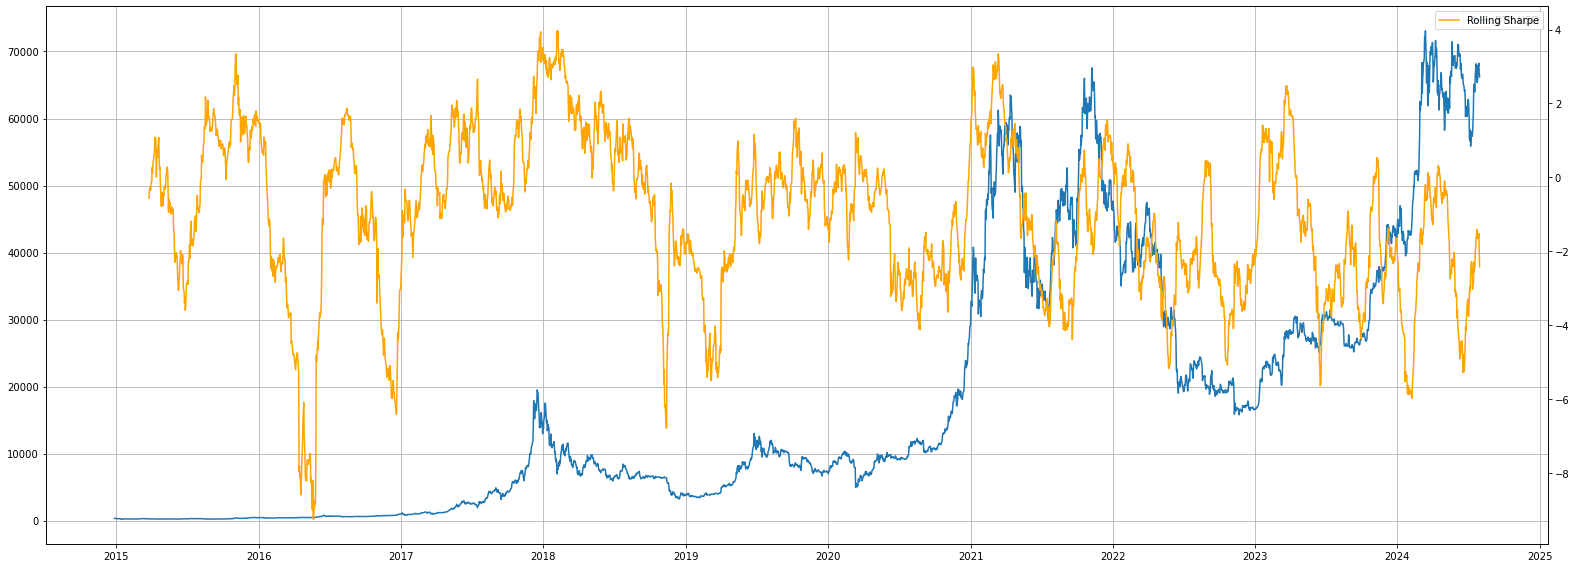

In [167]:
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (1,1)
rolling_sharpe = plt.subplot2grid(layout, (0,0))#, colspan=2)
# momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
# momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
# momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

rolling_sharpe_2 = rolling_sharpe.twinx()
_ = rolling_sharpe.plot(data.index, data[f'BTC-USD'], label='BTC-USD')
_ = rolling_sharpe_2.plot(data.index, data['rolling_sharpe_90'], label='Rolling Sharpe', color='orange')

# momentum_twin_ax_2 = momentum_ax_2.twinx()
# _ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
# _ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_3 = momentum_ax_3.twinx()
# _ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
# _ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_4 = momentum_ax_4.twinx()
# _ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
# _ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_5 = momentum_ax_5.twinx()
# _ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
# _ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

# momentum_twin_ax_6 = momentum_ax_6.twinx()
# _ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
# _ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = rolling_sharpe.grid()
_ = rolling_sharpe.legend()
# _ = rolling_sharpe.grid()
_ = rolling_sharpe_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
# _ = momentum_ax_4.grid()
# _ = momentum_ax_4.legend()
# _ = momentum_ax_5.grid()
# _ = momentum_ax_5.legend()
# _ = momentum_ax_6.grid()
# _ = momentum_ax_6.legend()

plt.tight_layout()

## Combined Moving Average Signals

In [92]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
data = (create_trend_strategy(data, ticker, mavg_start=10, mavg_end=100, mavg_stepsize=2, moving_avg_type='exponential', price_or_returns_calc='returns')
        .rename(columns={'BTC-USD_ribbon_thickness':'BTC-USD_ribbon_thickness_10_100_mavg','BTC-USD_trend_signal':'BTC-USD_trend_signal_10_100_mavg', 'BTC-USD_trend_strategy_returns':'BTC-USD_trend_strategy_returns_10_100_mavg',
                        'BTC-USD_trend_strategy_trades':'BTC-USD_trend_strategy_trades_10_100_mavg','BTC-USD_trend_slope_signal':'BTC-USD_trend_slope_signal_10_100_mavg','BTC-USD_trend_slope_strategy_returns':'BTC-USD_trend_slope_strategy_returns_10_100_mavg',
                        'BTC-USD_trend_slope_strategy_trades':'BTC-USD_trend_slope_strategy_trades_10_100_mavg'}))
data = (create_trend_strategy(data, ticker, mavg_start=30, mavg_end=300, mavg_stepsize=2, moving_avg_type='exponential', price_or_returns_calc='returns')
        .rename(columns={'BTC-USD_ribbon_thickness':'BTC-USD_ribbon_thickness_30_300_mavg','BTC-USD_trend_signal':'BTC-USD_trend_signal_30_300_mavg', 'BTC-USD_trend_strategy_returns':'BTC-USD_trend_strategy_returns_30_300_mavg',
                        'BTC-USD_trend_strategy_trades':'BTC-USD_trend_strategy_trades_30_300_mavg','BTC-USD_trend_slope_signal':'BTC-USD_trend_slope_signal_30_300_mavg','BTC-USD_trend_slope_strategy_returns':'BTC-USD_trend_slope_strategy_returns_30_300_mavg',
                        'BTC-USD_trend_slope_strategy_trades':'BTC-USD_trend_slope_strategy_trades_30_300_mavg'}))

File data found...reading ['BTC-USD'] data


In [93]:
## Combine the trend strategies
# Combine the two signals into one by averaging them
data['BTC-USD_combined_signal_10_100_30_300'] = (data['BTC-USD_trend_signal_10_100_mavg'] + data['BTC-USD_trend_signal_30_300_mavg']) / 2

# Round to get a signal of -1, 0, or 1
data['BTC-USD_combined_signal_10_100_30_300'] = np.sign(data['BTC-USD_combined_signal_10_100_30_300'])

# Get strategy returns
data['BTC-USD_combined_10_100_30_300_strategy_returns'] = data['BTC-USD_combined_signal_10_100_30_300'].shift(1) * data['BTC-USD_pct_returns']

# Get trade count
data['BTC-USD_combined_10_100_30_300_strategy_trades'] = data['BTC-USD_combined_signal_10_100_30_300'].diff()

In [102]:
## Combine the slope strategies
# Combine the two signals into one by averaging them
data['BTC-USD_combined_slope_signal_10_100_30_300'] = (data['BTC-USD_trend_slope_signal_10_100_mavg'] + data['BTC-USD_trend_slope_signal_30_300_mavg']) / 2

# Round to get a signal of -1, 0, or 1
data['BTC-USD_combined_slope_signal_10_100_30_300'] = np.sign(data['BTC-USD_combined_slope_signal_10_100_30_300'])

# Get strategy returns
data['BTC-USD_combined_slope_10_100_30_300_strategy_returns'] = data['BTC-USD_combined_slope_signal_10_100_30_300'].shift(1) * data['BTC-USD_pct_returns']

# Get trade count
data['BTC-USD_combined_slope_10_100_30_300_strategy_trades'] = data['BTC-USD_combined_slope_signal_10_100_30_300'].diff()

In [103]:
data[['BTC-USD_10_mavg','BTC-USD_100_mavg','BTC-USD_trend_signal_10_100_mavg','BTC-USD_trend_signal_30_300_mavg','BTC-USD_10_mavg_slope','BTC-USD_100_mavg_slope','BTC-USD_trend_slope_signal_10_100_mavg','BTC-USD_trend_slope_signal_30_300_mavg','BTC-USD_combined_signal_10_100_30_300','BTC-USD_combined_slope_signal_10_100_30_300']]

BTC-USD_10_mavg  BTC-USD_100_mavg  \
Date                                            
2015-10-24     1.120605e-02          0.002844   
2015-10-25     1.047644e-02          0.002930   
2015-10-26     9.609934e-03          0.002985   
2015-10-27     1.327198e-02          0.003516   
2015-10-28     1.756132e-02          0.004176   
2015-10-29     1.988167e-02          0.004694   
2015-10-30     2.446980e-02          0.005495   
2015-10-31     1.234425e-02          0.004550   
2015-11-01     1.661927e-02          0.005170   
2015-11-02     3.357557e-02          0.007244   
2015-11-03     4.872798e-02          0.009416   
2015-11-04     4.353971e-02          0.009630   
2015-11-05     2.448671e-02          0.008226   
2015-11-06     1.444197e-02          0.007453   
2015-11-07     1.764839e-02          0.007941   
2015-11-08     8.270199e-03          0.007112   
2015-11-09     1.012124e-02          0.007336   
2015-11-10    -1.248867e-02          0.004928   
2015-11-11    -2.411000e-02          0.003318   
2015-11-12    -3.906027e-03          0.004975   
2015-11-13    -3.948067e-03          0.004795   
2015-11-14    -5.307283e-03          0.004473   
2015-11-15    -1.130034e-02          0.003627   
2015-11-16    -3.234638e-03          0.004210   
2015-11-17    -2.591247e-04          0.004387   
2015-11-18    -4.854745e-04          0.004270   
2015-11-19    -4.984101e-03          0.003686   
2015-11-20    -6.378569e-03          0.003362   
2015-11-21    -2.449398e-03          0.003597   
2015-11-22    -3.333786e-03          0.003381   
2015-11-23    -3.562413e-03          0.003223   
2015-11-24    -4.603175e-03          0.002975   
2015-11-25     8.694657e-04          0.003421   
2015-11-26     1.427160e-02          0.004831   
2015-11-27     1.443896e-02          0.005036   
2015-11-28     1.147804e-02          0.004900   
2015-11-29     1.646938e-02          0.005574   
2015-11-30     1.642630e-02          0.005785   
2015-12-01     6.292179e-03          0.004892   
2015-12-02     3.492420e-03          0.004614   
2015-12-03     3.798438e-03          0.004626   
2015-12-04     4.183991e-03          0.004651   
2015-12-05     1.632234e-02          0.005964   
2015-12-06     1.327704e-02          0.005838   
2015-12-07     1.402115e-02          0.006066   
2015-12-08     2.067776e-02          0.006949   
2015-12-09     1.779321e-02          0.006906   
2015-12-10     1.365066e-02          0.006671   
2015-12-11     2.712357e-02          0.008276   
2015-12-12     1.537653e-02          0.007370   
2015-12-13     1.206167e-02          0.007168   
2015-12-14     1.423935e-02          0.007502   
2015-12-15     2.030326e-02          0.008296   
2015-12-16     1.255316e-02          0.007689   
2015-12-17     1.072798e-02          0.007587   
2015-12-18     1.178251e-02          0.007764   
2015-12-19     9.132758e-03          0.007555   
2015-12-20    -2.504184e-04          0.006564   
2015-12-21    -1.866644e-03          0.006253   
2015-12-22    -2.384043e-03          0.006036   
2015-12-23     4.770140e-04          0.006181   
2015-12-24     5.562056e-03          0.006622   
2015-12-25     4.817727e-03          0.006520   
2015-12-26    -1.137252e-02          0.004722   
2015-12-27    -6.886926e-03          0.004892   
2015-12-28    -5.868686e-03          0.004770   
2015-12-29    -1.928894e-04          0.005177   
2015-12-30    -2.829772e-03          0.004784   
2015-12-31    -6.331274e-04          0.004872   
2016-01-01     1.072713e-03          0.004949   
2016-01-02     5.025854e-04          0.004810   
2016-01-03    -1.026350e-03          0.004558   
2016-01-04     4.625590e-04          0.004610   
2016-01-05    -9.635862e-05          0.004467   
2016-01-06    -1.280541e-03          0.004248   
2016-01-07     1.121586e-02          0.005499   
2016-01-08     7.264153e-03          0.005182   
2016-01-09     3.689267e-03          0.004834   
2016-01-10     3.172848e-03          0.004755   
2016-01-11     2.773329e-03          0.0046

In [104]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_combined_10_100_30_300_strategy_returns',
                                                                      strategy_trade_count_col=f'BTC-USD_combined_10_100_30_300_strategy_trades',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [105]:
trend_metrics

{'annualized_return': 0.3940168373536832,
 'annualized_sharpe_ratio': -0.6657845306544247,
 'annualized_std_dev': 0.6367384786940714,
 'max_drawdown': -3.15448918738769,
 'max_drawdown_duration': Timedelta('3191 days 00:00:00'),
 'hit_rate': 0.3621604745551046,
 't_statistic': -1.7452637920692502,
 'p_value': 0.08103488466337512,
 'trade_count': 827.0}

In [106]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_combined_slope_10_100_30_300_strategy_returns',
                                                                      strategy_trade_count_col=f'BTC-USD_combined_slope_10_100_30_300_strategy_trades',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [107]:
trend_metrics

{'annualized_return': -0.062402352109913295,
 'annualized_sharpe_ratio': -1.0360664791613736,
 'annualized_std_dev': 0.5840130551443578,
 'max_drawdown': -3.924319263310664,
 'max_drawdown_duration': Timedelta('3191 days 00:00:00'),
 'hit_rate': 0.25413674679987514,
 't_statistic': -2.8216634381343537,
 'p_value': 0.004806981437784829,
 'trade_count': 839.0}

In [108]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns_10_100_mavg',
                                                                      strategy_trade_count_col=f'BTC-USD_trend_slope_strategy_trades_10_100_mavg',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [109]:
trend_metrics

{'annualized_return': 31.08333136975272,
 'annualized_sharpe_ratio': 3.4462660796740767,
 'annualized_std_dev': 0.6624008631457681,
 'max_drawdown': -2.1598597510065543,
 'max_drawdown_duration': Timedelta('188 days 00:00:00'),
 'hit_rate': 0.5448017483609117,
 't_statistic': 10.427153390785863,
 'p_value': 4.673318778982335e-25,
 'trade_count': 1206.0}

In [114]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns_30_300_mavg',
                                                                      strategy_trade_count_col=f'BTC-USD_trend_slope_strategy_trades_30_300_mavg',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [115]:
trend_metrics

{'annualized_return': 6.328880449842778,
 'annualized_sharpe_ratio': 2.32293284626719,
 'annualized_std_dev': 0.6827189809840049,
 'max_drawdown': -0.6153858065288471,
 'max_drawdown_duration': Timedelta('194 days 00:00:00'),
 'hit_rate': 0.536059943802685,
 't_statistic': 7.092986353103068,
 'p_value': 1.6083764304749284e-12,
 'trade_count': 525.0}

In [87]:
data.head(50)

BTC-USD  BTC-USD_pct_returns  BTC-USD_10_mavg  \
Date                                                           
2016-05-11  452.727997             0.004065        -0.000363   
2016-05-12  454.765991             0.004502         0.000521   
2016-05-13  455.670013             0.001988         0.000788   
2016-05-14  455.670990             0.000002         0.000645   
2016-05-15  457.567993             0.004163         0.001285   
2016-05-16  454.162994            -0.007442        -0.000302   
2016-05-17  453.782990            -0.000837        -0.000399   
2016-05-18  454.618988             0.001842         0.000008   
2016-05-19  438.714996            -0.034983        -0.006354   
2016-05-20  442.675995             0.009029        -0.003557   
2016-05-21  443.187988             0.001157        -0.002700   
2016-05-22  439.322998            -0.008721        -0.003795   
2016-05-23  444.154999             0.010999        -0.001105   
2016-05-24  445.980988             0.004111        -0.000157   
2016-05-25  449.598999             0.008112         0.001347   
2016-05-26  453.384003             0.008419         0.002633   
2016-05-27  473.463989             0.044289         0.010207   
2016-05-28  530.039978             0.119494         0.030077   
2016-05-29  526.232971            -0.007182         0.023303   
2016-05-30  533.864014             0.014501         0.021702   
2016-05-31  531.385986            -0.004642         0.016912   
2016-06-01  536.919983             0.010414         0.015731   
2016-06-02  537.971985             0.001959         0.013227   
2016-06-03  569.193970             0.058036         0.021374   
2016-06-04  572.726990             0.006207         0.018617   
2016-06-05  574.976990             0.003929         0.015946   
2016-06-06  585.536987             0.018366         0.016386   
2016-06-07  576.596985            -0.015268         0.010631   
2016-06-08  581.645020             0.008755         0.010290   
2016-06-09  574.630005            -0.012061         0.006226   
2016-06-10  577.469971             0.004942         0.005993   
2016-06-11  606.726990             0.050664         0.014115   
2016-06-12  672.783997             0.108874         0.031344   
2016-06-13  704.375977             0.046957         0.034182   
2016-06-14  685.559021            -0.026714         0.023110   
2016-06-15  694.468994             0.012997         0.021271   
2016-06-16  766.307983             0.103444         0.036212   
2016-06-17  748.908997            -0.022705         0.025500   
2016-06-18  756.226990             0.009772         0.022640   
2016-06-19  763.781006             0.009989         0.020340   
2016-06-20  737.226013            -0.034768         0.010320   
2016-06-21  666.651978            -0.095729        -0.008961   
2016-06-22  596.116028            -0.105806        -0.026570   
2016-06-23  623.976990             0.046737        -0.013241   
2016-06-24  665.299011             0.066224         0.001207   
2016-06-25  665.122986            -0.000265         0.000940   
2016-06-26  629.367004            -0.053758        -0.009006   
2016-06-27  655.275024             0.041165         0.000116   
2016-06-28  647.000977            -0.012627        -0.002201   
2016-06-29  639.890015            -0.010991        -0.003799   

            BTC-USD_10_mavg_slope  BTC-USD_100_mavg  BTC-USD_100_mavg_slope  \
Date                                                                          
2016-05-11              -0.000151          0.001525            8.365248e-06   
2016-05-12               0.000249          0.001584            8.351955e-06   
2016-05-13               0.000009          0.001592            1.096022e-05   
2016-05-14               0.000152          0.001561            2.251474e-07   
2016-05-15               0.000149          0.001612            2.593329e-06   
2016-05-16              -0.000485          0.001433            6.206540e-06   
2016-05-17              -0.000370          0.001388   

In [88]:
ticker = 'BTC-USD'
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
df_temp_results = pd.DataFrame(columns=performance_columns)
df_test = get_close_prices(start_date, end_date, ticker)
df_test = create_trend_strategy(df_test, ticker, mavg_start, mavg_end, mavg_stepsize)
# df_test['BTC-USD_trend_signal_test'] = df_test['BTC-USD_trend_signal'].shift(1)
# df_test['BTC-USD_trend_strategy_returns_test'] = df_test['BTC-USD_trend_signal_test'] * df_test['BTC-USD_pct_returns']
# df_test = df_test.dropna()
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_strategy_returns'] != 0).any()):
    trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
    df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
    trend_slope_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
                
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_metrics

File data found...reading ['BTC-USD'] data


TypeError: calculate_risk_and_performance_metrics() missing 1 required positional argument: 'strategy_trade_count_col'

In [ ]:
df_test.shape

In [ ]:
df_temp_results

In [ ]:
calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns_test')

In [ ]:
df_test[['BTC-USD','BTC-USD_pct_returns','BTC-USD_trend_slope_signal','BTC-USD_trend_strategy_returns']].head(1000)

In [ ]:
df_test.tail(200)

In [ ]:
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    print(window)

In [ ]:
df_test#.shape

In [ ]:
df_test.head()

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
df_mavg_results = get_mavg_strategy_performance(start_date, end_date, ticker_list)

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns')
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

In [ ]:
mavg_list = get_mavg_windows()
mavg_list

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
df_results = get_strategy_performance(start_date, end_date, ticker)

In [ ]:
df_test.head()

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

mavg_cond = (df_results.mavg_start == 10) & (df_results.mavg_end == 100) & (df_results.mavg_stepsize == 4)
_ = sharpe_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['sharpe_ratio'])
_ = sharpe_ax.grid()
_ = pnl_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['pnl'])
_ = pnl_ax.grid()

plt.tight_layout()

In [ ]:
df_results[mavg_cond]

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['PL=F','ES=F']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ES=F', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ES=F_trend_strategy_returns', trade_col='ES=F_trend_trade')
    _pnl = data[f'ES=F_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
ticker = ['PL=F','ES=F']
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
# data = create_trend_stra.tegy(data, ticker='PL=F', mavg_start=10, mavg_end=100, mavg_stepsize=4)

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
pl_prices_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
es_prices_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

_ = pl_prices_ax.plot(data.index, data['PL=F'])
_ = es_prices_ax.plot(data.index, data['ES=F'])

plt.tight_layout()

In [ ]:
mavg_end

In [ ]:
data.tail(500)

In [ ]:
ticker = 'ES=F'
moving_avg_type='simple'
for window in np.linspace(10, 100, 4):
    if moving_avg_type == 'simple':
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].rolling(int(window)).mean()
    else:
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].ewm(span=window).mean()
    data[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(data, column=f'{ticker}_{int(window)}_mavg',
                                                               periods=window)

In [ ]:
data.tail(500)

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
data = load_financial_data(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
results_SPY = []
ticker = ['SPY']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data[['Adj Close']].rename(columns={'Adj Close': 'SPY'})
    data = create_trend_strategy(data, ticker='SPY', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='SPY_trend_strategy_returns', trade_col='SPY_trend_trade')
    _pnl = data[f'SPY_mavg_trend_PnL'].sum()
    results_SPY.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_SPY

In [ ]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2

In [ ]:
data.head()

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['PL=F','ES=F']
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 31)
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price')

In [ ]:
sharpe_ratio(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns')

In [ ]:
data['BTC-USD_mavg_trend_PnL'].sum()

In [ ]:
data.head()

In [ ]:
data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [ ]:
sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')

In [ ]:
data[data['ETH-USD_trend_trade'].notnull()]

In [ ]:
mavg_start_SPY = 50
mavg_end_SPY = 200
mavg_stepsize_SPY = 2

In [ ]:
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    print(window)
    data_SPY[f'SPY_{window}_mavg'] = data_SPY['SPY'].rolling(int(window)).mean()
#     data_SPY[f'SPY_{window}_mavg_slope'] = (data_SPY[f'SPY_10.0_mavg'] - data_SPY[f'SPY_10.0_mavg'].shift(int(window)))/window
    data_SPY[f'SPY_{window}_mavg_slope'] = calculate_slope(data_SPY, column=f'SPY_{window}_mavg', periods=window)
    
data_SPY['SPY_ribbon_thickness'] = data_SPY[f'SPY_{float(mavg_start_SPY)}_mavg'] - data_SPY[f'SPY_{float(mavg_end_SPY)}_mavg']
data_SPY = get_returns_volatility(data_SPY, vol_range_list=[10, 20, 30, 60, 90], close_px_col='SPY')

## SPY Trend Signal and Trade
SPY_mavg_col_list = [f'SPY_{mavg}_mavg' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
SPY_mavg_slope_col_list = [f'SPY_{mavg}_mavg_slope' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
data_SPY['SPY_trend_signal'] = data_SPY[SPY_mavg_col_list].apply(trend_signal, axis=1)
data_SPY['SPY_trend_signal_diff'] = data_SPY['SPY_trend_signal'].diff().shift(1)
data_SPY['SPY_trend_trade'] = np.where(data_SPY['SPY_trend_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_slope_signal'] = data_SPY[SPY_mavg_slope_col_list].apply(slope_signal, axis=1)
data_SPY['SPY_trend_slope_signal_diff'] = data_SPY['SPY_trend_slope_signal'].diff().shift(1)
data_SPY['SPY_trend_slope_trade'] = np.where(data_SPY['SPY_trend_slope_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_signal_diff']
data_SPY['SPY_trend_slope_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_slope_signal_diff']
# data_SPY['SPY_trend_trade'] = np.where((np.abs(data_SPY['SPY_ribbon_thickness']) > 2000) &
#                                    (data_SPY['SPY_trend_signal_diff'] != 0), data_SPY['SPY_trend_signal_diff'], np.nan)

In [ ]:
data.shape

In [ ]:
data_SPY.shape

In [ ]:
# data = data.dropna()
# data = data[data.index.get_level_values('Date') >= '2018-12-14']
data_SPY = data_SPY[data_SPY.index.get_level_values('Date') >= '2019-06-14']

In [ ]:
data['BTC_mavg_slope_PnL'] = data['BTC_trend_slope_signal_diff'] * data['BTC_trend_slope_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_slope_signal')
BTC_cols.append('BTC_trend_slope_signal_diff')
BTC_cols.append('BTC_mavg_slope_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_slope_strategy_returns')
cond = (data['BTC_trend_slope_signal_diff'] != 0)
data[cond][BTC_cols]

In [ ]:
data['BTC_mavg_trend_PnL'] = data['BTC_trend_signal_diff'] * data['BTC_trend_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_signal')
BTC_cols.append('BTC_trend_signal_diff')
BTC_cols.append('BTC_mavg_trend_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_strategy_returns')
cond = (data['BTC_trend_trade'].notnull())
data[cond][BTC_cols]

In [ ]:
data['ETH_mavg_slope_PnL'] = data['ETH_trend_slope_signal_diff'] * data['ETH_trend_slope_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_slope_signal')
ETH_cols.append('ETH_trend_slope_signal_diff')
ETH_cols.append('ETH_mavg_slope_PnL')
cond = (data['ETH_trend_slope_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data['ETH_mavg_trend_PnL'] = data['ETH_trend_signal_diff'] * data['ETH_trend_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_signal')
ETH_cols.append('ETH_trend_signal_diff')
ETH_cols.append('ETH_mavg_trend_PnL')
cond = (data['ETH_trend_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data_SPY['SPY_mavg_trend_PnL'] = data_SPY['SPY_trend_signal_diff'] * data_SPY['SPY_trend_trade'] * -1
SPY_cols = [col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-5:] == 'slope')]
SPY_cols.append('SPY_trend_signal')
SPY_cols.append('SPY_trend_signal_diff')
SPY_cols.append('SPY_mavg_trend_PnL')
cond = (data_SPY['SPY_trend_trade'].notnull())
data_SPY[cond][SPY_cols]

In [ ]:
# Calculate the mean and standard deviation of the strategy returns
# mean_strategy_return = data['strategy_return'].mean()
# std_strategy_return = data['strategy_return'].std()

# Calculate annualized Sharpe Ratio (assuming 252 trading days in a year)
N = 255 #255 trading days in a year
rf =0.05 #1% risk free rate
cond = (data['BTC_trend_trade'].notnull())
sharpes = sharpe_ratio(data[cond]['BTC_trend_strategy_returns'], N, rf)

In [ ]:
data.head()

In [ ]:
print(f"BTC-USD_mavg_trend_PnL: {data['BTC-USD_mavg_trend_PnL'].sum()}")
cond = (data['BTC-USD_trend_signal_diff'] != 0)
print(f"BTC-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')}")
print(f"BTC-USD_mavg_slope_PnL: {data['BTC-USD_mavg_slope_PnL'].sum()}")
cond = (data['BTC-USD_trend_slope_signal_diff'] != 0)
print(f"BTC-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_slope_strategy_returns', trade_col='BTC-USD_trend_slope_trade')}")

In [ ]:
print(f"ETH-USD_mavg_trend_PnL: {data['ETH-USD_mavg_trend_PnL'].sum()}")
cond = (data['ETH-USD_trend_signal_diff'] != 0)
print(f"ETH-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')}")
print(f"ETH-USD_mavg_slope_PnL: {data['ETH-USD_mavg_slope_PnL'].sum()}")
cond = (data['ETH-USD_trend_slope_signal_diff'] != 0)
print(f"ETH-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_slope_strategy_returns', trade_col='ETH-USD_trend_slope_trade')}")

In [ ]:
[col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-4:] == 'mavg')]

In [ ]:
data_SPY.loc[data_SPY.index >= '2020-03-01'][['SPY','SPY_50.0_mavg','SPY_200.0_mavg','SPY_trend_signal','SPY_trend_signal_diff','SPY_mavg_trend_PnL','SPY_ribbon_thickness']].head(500)

In [ ]:
data.loc[data.index >= '2022-05-01'][['BTC-USD','BTC_20.0_mavg','BTC_40.0_mavg','BTC_60.0_mavg','BTC_80.0_mavg','BTC_100.0_mavg','BTC_120.0_mavg','BTC_140.0_mavg',
                                      'BTC_160.0_mavg','BTC_180.0_mavg','BTC_200.0_mavg','BTC_trend_signal','BTC_trend_signal_diff','BTC_mavg_trend_PnL','BTC_ribbon_thickness']].head(500)

In [ ]:
data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl = data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl['BTC-USD_mavg_trend_PnL_cum'] = data_Pnl['BTC-USD_mavg_trend_PnL'].cumsum()

In [ ]:
data[data['BTC-USD_trend_trade'].notnull()].head(100)

In [ ]:
data['BTC-USD_ribbon_thickness_diff'] = data['BTC-USD_ribbon_thickness'].diff()

In [ ]:
data.index[3-1]

In [ ]:
data.head(500)

In [ ]:
for j in range(1, 4):
    print(j)

In [ ]:
data['BTC-USD_ribbon_thickness_signal'] = np.nan
data.loc[data.index[0:3], 'BTC-USD_ribbon_thickness_signal'] = 0
lookback_period = 3
for i in range(lookback_period, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] > data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 1
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] < data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = -1
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Buy'
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 0#data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal']

data['BTC-USD_ribbon_thickness_position'] = data['BTC-USD_ribbon_thickness_signal'].diff()
        
data['BTC-USD_ribbon_thickness_PnL'] = data['BTC-USD_ribbon_thickness_position'] * data['BTC-USD']
data['BTC-USD_ribbon_thickness_cum_PnL'] = data['BTC-USD_ribbon_thickness_PnL'].cumsum()

In [ ]:
trend_buy_signal = (data['BTC-USD_trend_signal'] == 1)
trend_sell_signal = (data['BTC-USD_trend_signal'] == -1)
ribbon_thickness_buy_signal = (data['BTC-USD_ribbon_thickness_signal'] == 1)
ribbon_thickness_sell_signal = (data['BTC-USD_ribbon_thickness_signal'] == -1)
data['BTC-USD_trend_ribbon_thickness_combo_signal'] = np.where(trend_buy_signal & ribbon_thickness_buy_signal, 1,
                                                              np.where(trend_sell_signal & ribbon_thickness_sell_signal, -1, 0))
data['BTC-USD_trend_ribbon_thickness_combo_position'] = data['BTC-USD_trend_ribbon_thickness_combo_signal'].diff()
data['BTC-USD_trend_ribbon_thickness_combo_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_position'] * data['BTC-USD']
data['BTC-USD_trend_ribbon_thickness_combo_cum_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_PnL'].cumsum()

In [ ]:
data['BTC-USD_trend_ribbon_thickness_combo_PnL'].sum()

In [ ]:
data[['BTC-USD','BTC-USD_ribbon_thickness','BTC-USD_ribbon_thickness_diff','BTC-USD_ribbon_thickness_signal','BTC-USD_trend_signal','BTC-USD_ribbon_thickness_position','BTC-USD_ribbon_thickness_PnL',
     'BTC-USD_ribbon_thickness_cum_PnL']].head(500)

In [ ]:
data['BTC-USD_ribbon_thickness_PnL'].sum()

In [ ]:
data['BTC-USD_ribbon_thickness_slope'] = calculate_slope(data, column='BTC-USD_ribbon_thickness', periods=50)
data['BTC-USD_ribbon_thickness_slope_diff'] = data['BTC-USD_ribbon_thickness_slope'].diff()
data['BTC-USD_ribbon_thickness_slope_position'] = np.nan
data.loc[data.index[0], 'BTC-USD_ribbon_thickness_slope_position'] = 'No Position'
for i in range(3, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] > 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Buy'
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] < 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Sell'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_slope_position'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Buy'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_position'] = data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position']
        
        

In [ ]:
data.head(100)

In [ ]:
np.abs(data['BTC-USD_trend_slope_signal_diff']).sum()

In [ ]:
ticker = 'BTC-USD'
data[f'{ticker}_trend_slope_signal_diff'] = data[f'{ticker}_trend_slope_signal'].diff().shift(1)
data[f'{ticker}_trend_slope_trade'] = np.where(data[f'{ticker}_trend_slope_signal_diff'] != 0, data[f'{ticker}'], 0)

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
# _ = mavg_ax.plot(data.index, data['BTC-USD_pct_returns'], label='Returns', linestyle='--', color='red', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax2.plot(data.index, data[f'BTC-USD_{int(window)}_mavg_slope'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['BTC-USD_trend_slope_signal_diff'] == 1)
sell_cond = (data['BTC-USD_trend_slope_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# pnl_cond = (data['BTC-USD_trend_slope_trade'].notnull())
# _ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_slope_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

## data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness'])

In [ ]:
data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness_slope'])

In [ ]:
data.iloc[i-0]['BTC-USD_ribbon_thickness_diff']

In [ ]:
all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_diff'] > 0 for j in range(1,4))

In [ ]:
data.loc[data.index[i-0], 'BTC-USD_ribbon_thickness_diff']# > 0 for j in range(1,4)

In [ ]:
data.loc[data.index[i:]]

In [ ]:
data#.shape

In [ ]:
data.groupby(['BTC-USD_ribbon_thickness_position']).size()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['ETH-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['ETH-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['ETH-USD_trend_signal_diff'] == 1)
sell_cond = (data['ETH-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'ETH-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['ETH-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['ETH-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['ETH-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['ETH-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['ETH-USD_trend_slope_signal'] == 1)
# sell_cond = (data['ETH-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('ETH')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('ETH Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('ETH Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('ETH Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('ETH Cumulative P&L')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (3,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    _ = mavg_ax.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg'], label=f'{window} MAVG', linestyle='--')
    
buy_cond = (data_SPY['SPY_trend_signal_diff'] == 1)
sell_cond = (data_SPY['SPY_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data_SPY['SPY_trend_slope_signal'] == 1)
# sell_cond = (data_SPY['SPY_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('SPY')

_ = slope_ax.grid()
_ = slope_ax.legend(ncol=4, loc='upper left')
_ = slope_ax2.legend(ncol=4, loc='upper right')
_ = slope_ax.set_title('SPY Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('SPY Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.set_title('SPY Ribbon Thickness')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['BTC_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(loc='upper left')
_ = mavg_ax2.legend(loc='upper right')
_ = mavg_ax.set_title('BTC')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

# _ = mavg_ax.plot(data.index, data['BTC_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=3)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=3)
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['ETH_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend()
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
col_list = [col for col in data.columns if (col[:3] == 'BTC') & (col[-4:] == 'mavg')]

In [ ]:
data[col_list].head()

In [ ]:
data.head()

In [ ]:
window_list = [window for window in np.linspace(10, 100, 10)]
for i in np.arange(len(window_list)-1):
    print(i, window_list[i], window_list[i+1])
    data[f'signal_{window_list[i]}_{window_list[i+1]}'] = np.where(data[f'BTC_{window_list[i]}_mavg'] >
                                                                  data[f'BTC_{window_list[i+1]}_mavg'], 1, 0)

In [ ]:
data.head(100)

In [ ]:
data['signal'] = np.where(data['BTC_short_mavg'] > data['BTC_long_mavg'], 1, -1)

In [ ]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot(figsize=(15,7))
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()